# ***Requirements***

In [ ]:
!pip install jenkspy
!pip install graphviz
!pip install mlxtend

In [ ]:
import gc
# del df
gc.collect()

432

# ***Importing Libraries***

In [1]:
import pandas as pd

import numpy as np

from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.decomposition import PCA

import statsmodels.api as sm
from   statsmodels.api import OLS

import mlxtend
from   mlxtend.evaluate import confusion_matrix
from   mlxtend.plotting import plot_confusion_matrix
from   mlxtend.evaluate import confusion_matrix

import matplotlib.pyplot as plt
import pydotplus
import graphviz

from scipy.stats import ttest_ind
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# import jenkspy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# ***Functions***

In [2]:
def _my_plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Reading Dataset***

In [5]:
df = pd.read_csv('/content/drive/MyDrive/FDM/Preprocessed/df_droped.csv', index_col='Unnamed: 0')

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# ***Setup***

## ***Seperating Columns***

In [6]:
categorical_columns = [
                       'FEDUC',
                       'FHISPX',
                       'FRACE6',
                       'MEDUC',
                       'MHISPX',
                       'NO_INFEC',
                       'NO_MMORB',
                       'NO_RISKS',
                       'PAY',
                       'PAY_REC',
                       'FRACE15',
                       'FRACE31',
                       'DMAR',
                       'IP_GON',
                       'LD_INDL',
                       'MM_AICU',
                       'MTRAN',
                       'RF_CESAR',
                       'MBSTATE_REC',
                       'smoked',
                       'first_live_birth',
                       'first_birth',
                       'had_priordead',
                       'MRACE31',
                       'MRACE15',
                       'RESTATUS',
                       'SEX',
                       'MRACE6'


]

In [7]:
numerical_columns = [
                     'BMI',
                     'CIG_0',
                     'FAGECOMB',
                     'M_Ht_In',
                     'PRECARE',
                     'PREVIS',
                     'PRIORDEAD',
                     'PRIORLIVE',
                     'PRIORTERM',
                     'RF_CESARN',
                     'WTGAIN',
                     'ILLB_R',
                     'ILOP_R',
                     'ILP_R',
                     'PWgt_R',
                     'DLMP_MM', ## ???
                     'DLMP_YY',
                     'DOB_MM', ## ???
                     'MAGER',
                     'pregnancy_length'
                     
]

## ***ZScore on numerical values***

In [8]:
for c in numerical_columns:
  df[c] = zscore(df[c])

## ***Get Dummy on categorical values***

In [9]:
df = pd.get_dummies(df, columns=categorical_columns)

## ***Removing Outliers***

In [10]:
df.shape

(3611596, 200)

In [11]:
for c in numerical_columns:
  df.drop(df[(df[c] < -3) | (df[c] > 3)].index, inplace=True)

In [12]:
df.shape

(2961468, 200)

## ***Sampling***

In [13]:
sampled_df = df.sample(n=600000, random_state=7)

In [14]:
sampled_df.shape

(600000, 200)

In [15]:
for c in df.columns:
  stat, p = ttest_ind(df[c], sampled_df[c])
  if p > 0.05:
    pass
  else:
    print(f'{c}: Probably different distributions')

FRACE31_9.0: Probably different distributions
FRACE31_11.0: Probably different distributions
FRACE31_29.0: Probably different distributions
MRACE15_7: Probably different distributions


## ***Deviding X & Y*** 

In [16]:
X = sampled_df.drop(columns=['DBWT'])

### ***Logistic Y***

In [17]:
reg11_class = ['LessThan500','500-1000','1000-1500','1500-2000','2000-2500',
          '2500-3000','3000-3500','3500-4000','4000-4500','4500-5000',
           'GreaterThan5000']
Y = pd.cut(sampled_df['DBWT'],
                        bins = [227,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,8165], labels=reg11_class,include_lowest=True)

In [ ]:
reg3_class = ['low', 'medium', 'high']
Y = pd.cut(sampled_df['DBWT'],
                        bins = [227, 2500, 4500, 8165], labels=reg3_class,include_lowest=True)

In [ ]:
reg6_class = ['LessThan1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', 'GreaterThan5000']
Y = pd.cut(sampled_df['DBWT'],
                        bins = [227, 1000, 2000, 3000, 4000, 5000, 8165], labels=reg6_class,include_lowest=True)

In [17]:
reg2_class = ['low', 'normal']
Y = pd.cut(sampled_df['DBWT'],
                        bins = [227, 2900, 8165], labels=reg2_class,include_lowest=True)

### ***Linear Y***

In [ ]:
Y = sampled_df[['DBWT']]

## ***PCA***

### ***30 Components***

In [ ]:
pca30 = PCA(n_components=30)
principComp30 = pca30.fit_transform(X)

In [ ]:
pca30.explained_variance_ratio_

array([0.14, 0.09, 0.08, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03,
       0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [ ]:
np.cumsum(pca30.explained_variance_ratio_)

array([0.14, 0.22, 0.31, 0.37, 0.42, 0.46, 0.51, 0.54, 0.58, 0.61, 0.64,
       0.67, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.79, 0.81, 0.82, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.89, 0.9 , 0.91, 0.92])

In [ ]:
X = pd.DataFrame(principComp30)

### ***50 Components***

In [18]:
pca50 = PCA(n_components=50)
principComp50 = pca50.fit_transform(X)

In [19]:
pca50.explained_variance_ratio_

array([0.13775619, 0.08701802, 0.08335464, 0.05707803, 0.05152471,
       0.04637798, 0.04326985, 0.03763768, 0.0368246 , 0.03270628,
       0.03119333, 0.0275287 , 0.02376812, 0.02122705, 0.02075864,
       0.02031201, 0.01824294, 0.01645436, 0.01549215, 0.01431043,
       0.01312316, 0.01163077, 0.01050938, 0.00994236, 0.00966453,
       0.00885266, 0.00771986, 0.00756499, 0.00723351, 0.00641722,
       0.00626955, 0.0054549 , 0.00532845, 0.00468925, 0.00406752,
       0.00391248, 0.00372425, 0.00342408, 0.00313972, 0.00291973,
       0.00274041, 0.00269383, 0.00264588, 0.00245903, 0.00203762,
       0.00189977, 0.00184688, 0.00178995, 0.00155857, 0.00147463])

In [20]:
np.cumsum(pca50.explained_variance_ratio_)

array([0.13775619, 0.22477421, 0.30812885, 0.36520688, 0.41673159,
       0.46310957, 0.50637942, 0.5440171 , 0.5808417 , 0.61354798,
       0.64474131, 0.67227001, 0.69603813, 0.71726518, 0.73802382,
       0.75833582, 0.77657876, 0.79303312, 0.80852527, 0.8228357 ,
       0.83595887, 0.84758964, 0.85809902, 0.86804138, 0.87770591,
       0.88655857, 0.89427843, 0.90184342, 0.90907693, 0.91549415,
       0.9217637 , 0.9272186 , 0.93254706, 0.9372363 , 0.94130383,
       0.94521631, 0.94894055, 0.95236464, 0.95550436, 0.95842409,
       0.9611645 , 0.96385833, 0.96650421, 0.96896323, 0.97100086,
       0.97290063, 0.9747475 , 0.97653745, 0.97809603, 0.97957066])

In [21]:
X = pd.DataFrame(principComp50)

In [22]:
# X =sm.add_constant(X.values)

### ***100 Components***

In [17]:
pca100 = PCA(n_components=100)
principComp100 = pca100.fit_transform(X)

In [18]:
pca100.explained_variance_ratio_

array([1.37756187e-01, 8.70180207e-02, 8.33546449e-02, 5.70780309e-02,
       5.15247064e-02, 4.63779795e-02, 4.32698488e-02, 3.76376823e-02,
       3.68246020e-02, 3.27062790e-02, 3.11933285e-02, 2.75287022e-02,
       2.37681165e-02, 2.12270517e-02, 2.07586355e-02, 2.03120052e-02,
       1.82429390e-02, 1.64543580e-02, 1.54921510e-02, 1.43104311e-02,
       1.31231648e-02, 1.16307747e-02, 1.05093762e-02, 9.94236245e-03,
       9.66452894e-03, 8.85265769e-03, 7.71985980e-03, 7.56499358e-03,
       7.23351082e-03, 6.41722166e-03, 6.26954813e-03, 5.45490481e-03,
       5.32845474e-03, 4.68924606e-03, 4.06752170e-03, 3.91248242e-03,
       3.72424568e-03, 3.42408618e-03, 3.13972504e-03, 2.91974923e-03,
       2.74042444e-03, 2.69384156e-03, 2.64587939e-03, 2.45909677e-03,
       2.03766465e-03, 1.90030791e-03, 1.84692536e-03, 1.79014923e-03,
       1.56082410e-03, 1.47509075e-03, 1.45356286e-03, 1.38733780e-03,
       1.32895832e-03, 1.15476909e-03, 1.12318931e-03, 1.12021526e-03,
      

In [19]:
np.cumsum(pca100.explained_variance_ratio_)

array([0.13775619, 0.22477421, 0.30812885, 0.36520688, 0.41673159,
       0.46310957, 0.50637942, 0.5440171 , 0.5808417 , 0.61354798,
       0.64474131, 0.67227001, 0.69603813, 0.71726518, 0.73802382,
       0.75833582, 0.77657876, 0.79303312, 0.80852527, 0.8228357 ,
       0.83595887, 0.84758964, 0.85809902, 0.86804138, 0.87770591,
       0.88655857, 0.89427843, 0.90184342, 0.90907693, 0.91549415,
       0.9217637 , 0.9272186 , 0.93254706, 0.9372363 , 0.94130383,
       0.94521631, 0.94894055, 0.95236464, 0.95550437, 0.95842412,
       0.96116454, 0.96385838, 0.96650426, 0.96896336, 0.97100102,
       0.97290133, 0.97474826, 0.9765384 , 0.97809923, 0.97957432,
       0.98102788, 0.98241522, 0.98374418, 0.98489895, 0.98602214,
       0.98714235, 0.9881075 , 0.98903001, 0.98978084, 0.99050365,
       0.99112608, 0.99170132, 0.99227337, 0.99283042, 0.99338223,
       0.99392945, 0.99441863, 0.99487565, 0.99530385, 0.99569349,
       0.99605239, 0.99638609, 0.99669619, 0.99697761, 0.99721

In [20]:
X = pd.DataFrame(principComp100)

## ***Train Test Split***

In [23]:
X.index = Y.index

In [ ]:
X = sm.add_constant(X)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [25]:
print(f"X_train:{X_train.shape} Y_train: {Y_train.shape}\nX_test: {X_test.shape} Y_test:  {Y_test.shape}")

X_train:(480000, 50) Y_train: (480000,)
X_test: (120000, 50) Y_test:  (120000,)


## ***Using OLS to remove columns with big P-value***

In [ ]:
pre_ols_model = OLS(Y_train, X_train)

In [ ]:
pre_ols_result = pre_ols_model.fit()

In [ ]:
pre_ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     3295.
Date:                Sat, 10 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:27:03   Log-Likelihood:            -3.6344e+06
No. Observations:              480000   AIC:                         7.269e+06
Df Residuals:                  479949   BIC:                         7.269e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3289.6311      0.678   4849.294      0.000    3288.302    3290.961
0             17.0578      0.372     45.832      0.000      16.328      17.787
1            -24.9735      0.469    -53.284      0.000     -25.892     -24.055
2            -50.0157      0.479   -104.405      0.000     -50.955     -49.077
3            -83.2776      0.578   -143.969      0.000     -84.411     -82.144
4             28.2719      0.610     46.385      0.000      27.077      29.466
5            -26.7763      0.642    -41.739      0.000     -28.034     -25.519
6            -91.0276      0.664   -137.037      0.000     -92.330     -89.726
7            -80.7556      0.713   -113.337      0.000     -82.152     -79.359
8            -48.9706      0.720    -67.993      0.000     -50.382     -47.559
9            164.7591      0.764    215.548      0.000     163.261     166.257
10           -14.7468      0.783    -18.844      0.000     -16.281     -13.213
11           106.5972      0.833    127.924      0.000     104.964     108.230
12           -12.1983      0.896    -13.613      0.000     -13.955     -10.442
13            42.7550      0.949     45.054      0.000      40.895      44.615
14          -102.0846      0.959   -106.444      0.000    -103.964    -100.205
15           -13.6415      0.970    -14.069      0.000     -15.542     -11.741
16            44.7038      1.023     43.699      0.000      42.699      46.709
17           -12.9479      1.077    -12.018      0.000     -15.060     -10.836
18           -23.9533      1.111    -21.565      0.000     -26.130     -21.776
19            33.4201      1.156     28.920      0.000      31.155      35.685
20            10.8895      1.206      9.028      0.000       8.525      13.254
21            -6.3027      1.281     -4.918      0.000      -8.814      -3.791
22           -21.4553      1.348    -15.919      0.000     -24.097     -18.814
23             6.5420      1.388      4.715      0.000       3.822       9.261
24            -9.3478      1.406     -6.649      0.000     -12.103      -6.592
25            28.8905      1.470     19.660      0.000      26.010      31.771
26           -15.9978      1.573    -10.168      0.000     -19.081     -12.914
27           -48.6333      1.590    -30.586      0.000     -51.750     -45.517
28           -13.3348      1.625     -8.206      0.000     -16.520     -10.150
29          -112.0041      1.727    -64.849      0.000    -115.389    -108.619
30            -0.8149      1.745     -0.467      0.641      -4.236       2.606
31            13.7362      1.871      7.342      0.000      10.069      17.403
32             7.3588      1.893      3.887      0.000       3.648      11.069
33             5.8459      2.019      2.895      0.004       1.888       9.803
34             3.4720      2.168      1.602      0.109      -0.777       7.721
35

### ***Removing Columns***

In [26]:
X_train.drop(columns=[30,34,35,36,43], inplace=True)
X_test.drop(columns=[30,34,35,36,43], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# ***Modeling***

## ***Linear Regression***

### ***sm.OLS:***

In [ ]:
ols_model = OLS(Y_train, X_train)

In [ ]:
ols_result = ols_model.fit()

In [ ]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     3661.
Date:                Sat, 10 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:49:24   Log-Likelihood:            -3.6344e+06
No. Observations:              480000   AIC:                         7.269e+06
Df Residuals:                  479954   BIC:                         7.269e+06
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3289.6314      0.678   4849.282      0.000    3288.302    3290.961
0             17.0579      0.372     45.832      0.000      16.328      17.787
1            -24.9726      0.469    -53.282      0.000     -25.891     -24.054
2            -50.0157      0.479   -104.404      0.000     -50.955     -49.077
3            -83.2780      0.578   -143.970      0.000     -84.412     -82.144
4             28.2730      0.610     46.387      0.000      27.078      29.468
5            -26.7763      0.642    -41.739      0.000     -28.034     -25.519
6            -91.0277      0.664   -137.037      0.000     -92.330     -89.726
7            -80.7549      0.713   -113.336      0.000     -82.151     -79.358
8            -48.9703      0.720    -67.993      0.000     -50.382     -47.559
9            164.7615      0.764    215.551      0.000     163.263     166.260
10           -14.7473      0.783    -18.845      0.000     -16.281     -13.214
11           106.5990      0.833    127.926      0.000     104.966     108.232
12           -12.1983      0.896    -13.613      0.000     -13.955     -10.442
13            42.7532      0.949     45.052      0.000      40.893      44.613
14          -102.0815      0.959   -106.441      0.000    -103.961    -100.202
15           -13.6424      0.970    -14.069      0.000     -15.543     -11.742
16            44.7037      1.023     43.699      0.000      42.699      46.709
17           -12.9494      1.077    -12.019      0.000     -15.061     -10.838
18           -23.9513      1.111    -21.563      0.000     -26.128     -21.774
19            33.4264      1.156     28.925      0.000      31.161      35.691
20            10.8852      1.206      9.025      0.000       8.521      13.249
21            -6.3040      1.281     -4.919      0.000      -8.816      -3.792
22           -21.4532      1.348    -15.917      0.000     -24.095     -18.812
23             6.5417      1.388      4.715      0.000       3.822       9.261
24            -9.3448      1.406     -6.646      0.000     -12.100      -6.589
25            28.8948      1.470     19.663      0.000      26.015      31.775
26           -15.9993      1.573    -10.169      0.000     -19.083     -12.916
27           -48.6308      1.590    -30.584      0.000     -51.747     -45.514
28           -13.3374      1.625     -8.208      0.000     -16.522     -10.152
29          -112.0069      1.727    -64.850      0.000    -115.392    -108.622
31            13.7357      1.871      7.342      0.000      10.069      17.403
32             7.3583      1.893      3.887      0.000       3.648      11.069
33             5.8501      2.019      2.897      0.004       1.893       9.808
37            52.1480      2.362     22.077      0.000      47.518      56.778
38            34.1962      2.467     13.860      0.000      29.360      39.032
39

In [ ]:
ols_y_pred = ols_result.predict(X_test)

In [ ]:
r_squared(Y_test.values.ravel(), ols_y_pred)

0.2528374226115

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,ols_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,ols_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,ols_y_pred))}")

[+] Mean Absolute Error = 363.4576396703479
[+] Mean Square Error = 222061.65442476436
[+] Root Mean Squared Error = 471.2341821480742


### ***LinearRegression:***

In [ ]:
lr_model = LinearRegression().fit(X_train,Y_train)

In [ ]:
lr_y_pred = lr_model.predict(X_test)

In [ ]:
lr_model.score(X_test,Y_test)

0.2528374226115

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,lr_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,lr_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,lr_y_pred))}")

[+] Mean Absolute Error = 363.45763967034793
[+] Mean Square Error = 222061.65442476436
[+] Root Mean Squared Error = 471.2341821480742


### ***Ridge:***

In [ ]:
rg_model = Ridge(alpha=.5).fit(X_train,Y_train)

In [ ]:
rg_y_pred = rg_model.predict(X_test)

In [ ]:
rg_model.score(X_test,Y_test)

0.25283743929919833

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,rg_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,rg_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,rg_y_pred))}")

[+] Mean Absolute Error = 363.45762113510466
[+] Mean Square Error = 222061.64946507016
[+] Root Mean Squared Error = 471.2341768856225


### ***Lasso:***

In [ ]:
ls_model = Lasso(alpha=0.1).fit(X_train,Y_train)

In [ ]:
ls_y_pred = ls_model.predict(X_test)

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,ls_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,ls_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,ls_y_pred))}")

[+] Mean Absolute Error = 363.4378726775435
[+] Mean Square Error = 222056.3011904071
[+] Root Mean Squared Error = 471.2285020989362


### ***Decision Tree Regressor***

In [ ]:
dtr = DecisionTreeRegressor().fit(X_train,Y_train)

In [ ]:
dtr_y_pred = dtr.predict(X_test)

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,dtr_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,dtr_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,dtr_y_pred))}")

[+] Mean Absolute Error = 517.7256791666666
[+] Mean Square Error = 443736.95220625
[+] Root Mean Squared Error = 666.1358361522446


In [ ]:
dtr.score(X_test,Y_test)

-0.4930251949702018

In [ ]:
r_squared(Y_test.values.ravel(),dtr_y_pred)

-0.4930251949702018

### ***Random Forest Regressor***

In [ ]:
rfr = RandomForestRegressor(n_estimators=100).fit(X_train,Y_train.values.ravel())

In [ ]:
rfr_y_pred = rfr.predict(X_test)

In [ ]:
print(f"[+] Mean Absolute Error = {metrics.mean_absolute_error(Y_test,rfr_y_pred)}")
print(f"[+] Mean Square Error = {metrics.mean_squared_error(Y_test,rfr_y_pred)}")
print(f"[+] Root Mean Squared Error = {np.sqrt(metrics.mean_squared_error(Y_test,rfr_y_pred))}")

[+] Mean Absolute Error = 356.42059031904756
[+] Mean Square Error = 213002.48813343426
[+] Root Mean Squared Error = 461.52192595090673


In [ ]:
rfr.score(X_test,Y_test)

0.28331846200011024

## ***Logistic Regression***

### ***Logistic: 2 Categories***

In [ ]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_test)/len(Y_test))*100

Distribution of Each Category in Test Data:


normal    79.799167
low       20.200833
Name: DBWT, dtype: float64

In [ ]:
print('Distribution of Each Category in Train Data:')
(pd.value_counts(Y_train)/len(Y_train))*100

Distribution of Each Category in Train Data:


normal    79.772083
low       20.227917
Name: DBWT, dtype: float64

#### ***LogisticRegression***

In [ ]:
reg2_lr = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [ ]:
reg2_lr.score(X_test, Y_test.values.ravel())

0.8207

In [ ]:
reg2_y_pred = reg2_lr.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg2_y_pred))

              precision    recall  f1-score   support

         low       0.66      0.23      0.35     24241
      normal       0.83      0.97      0.90     95759

    accuracy                           0.82    120000
   macro avg       0.75      0.60      0.62    120000
weighted avg       0.80      0.82      0.78    120000



In [ ]:
reg2_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg2_y_pred, 
                      binary=False)

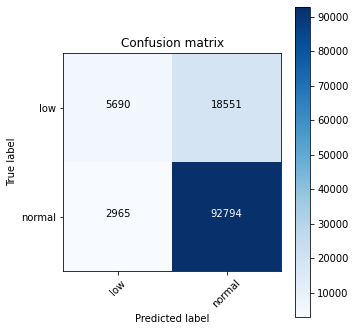

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg2_cm, classes=reg2_class,
                      title='Confusion matrix')

In [ ]:
reg2_mlcm=multilabel_confusion_matrix(Y_test, reg2_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(reg2_mlcm[i])

 [+] low 
[[92794  2965]
 [18551  5690]]
 [+] normal 
[[ 5690 18551]
 [ 2965 92794]]


#### ***Random Forest Classifier***

In [ ]:
reg2_rf = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train.values.ravel())

In [ ]:
reg2_rf.score(X_test, Y_test.values.ravel())

0.8189

In [ ]:
reg2_rf_y_pred = reg2_rf.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg2_rf_y_pred))

              precision    recall  f1-score   support

         low       0.67      0.20      0.31     24241
      normal       0.83      0.97      0.90     95759

    accuracy                           0.82    120000
   macro avg       0.75      0.59      0.60    120000
weighted avg       0.80      0.82      0.78    120000



In [ ]:
reg2_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg2_rf_y_pred, 
                      binary=False)

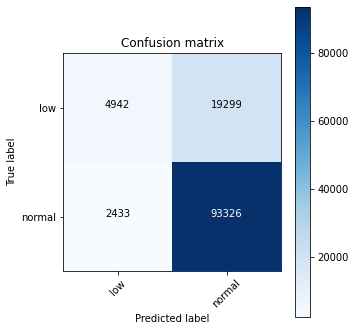

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg2_rf_cm, classes=reg2_class,
                      title='Confusion matrix')

In [ ]:
reg2_rf_mlcm=multilabel_confusion_matrix(Y_test, reg2_rf_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(reg2_rf_mlcm[i])

 [+] low 
[[93326  2433]
 [19299  4942]]
 [+] normal 
[[ 4942 19299]
 [ 2433 93326]]


#### ***Decision Tree Classifer***

In [ ]:
reg2_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

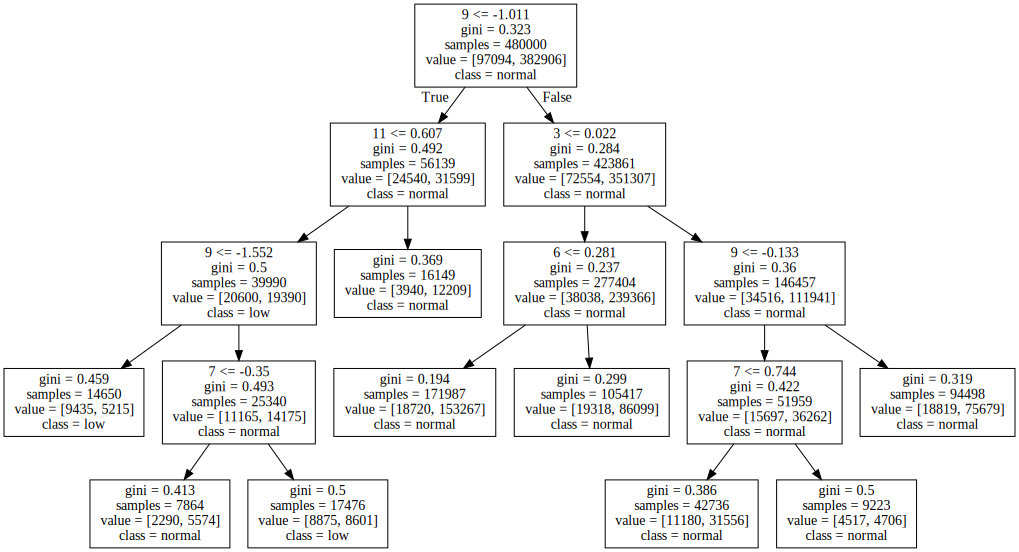

<Figure size 1080x1080 with 0 Axes>

In [ ]:
export_graphviz(reg2_dt, out_file="/content/drive/MyDrive/FDM/documents/reg2_dt_tree.dot", class_names=['low', 'normal'],feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg2_dt_tree.dot") as f:
  dot_graph = f.read()
dt3graph = pydotplus.graph_from_dot_data(dot_graph) 
dt3graph.write_svg("/content/drive/MyDrive/FDM/documents/reg2dt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph)

In [ ]:
reg2_dt.score(X_test, Y_test.values.ravel())

0.806825

In [ ]:
reg2_dt_y_pred = reg2_dt.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg2_dt_y_pred))

              precision    recall  f1-score   support

         low       0.57      0.18      0.28     24241
      normal       0.82      0.96      0.89     95759

    accuracy                           0.81    120000
   macro avg       0.70      0.57      0.58    120000
weighted avg       0.77      0.81      0.77    120000



In [ ]:
reg2_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg2_dt_y_pred, 
                      binary=False)

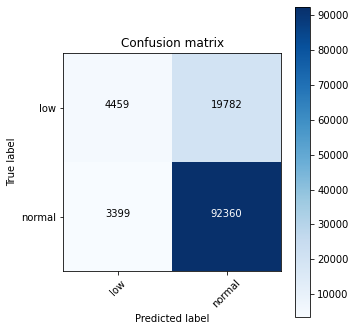

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg2_dt_cm, classes=reg2_class,
                      title='Confusion matrix')

In [ ]:
reg2_dt_mlcm=multilabel_confusion_matrix(Y_test, reg2_dt_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(reg2_dt_mlcm[i])

 [+] low 
[[92360  3399]
 [19782  4459]]
 [+] normal 
[[ 4459 19782]
 [ 3399 92360]]


#### ***Neural Network***

In [ ]:
nn2 = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [ ]:
nn2.score(X_test,Y_test)

0.8138583333333334

In [ ]:
nn2_y_pred = nn2.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, nn2_y_pred))

              precision    recall  f1-score   support

         low       0.58      0.28      0.38     24241
      normal       0.84      0.95      0.89     95759

    accuracy                           0.81    120000
   macro avg       0.71      0.62      0.63    120000
weighted avg       0.79      0.81      0.79    120000



In [ ]:
nn2_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn2_y_pred, 
                      binary=False)

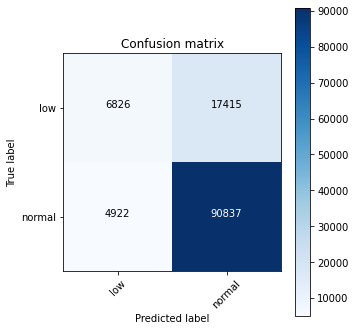

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(nn2_cm, classes=reg2_class,
                      title='Confusion matrix')

In [ ]:
nn2_mlcm=multilabel_confusion_matrix(Y_test, nn2_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(nn2_mlcm[i])

 [+] low 
[[90837  4922]
 [17415  6826]]
 [+] normal 
[[ 6826 17415]
 [ 4922 90837]]


#### ***GaussionNB***

In [ ]:
gnb2 = GaussianNB().fit(X_train, Y_train)

In [ ]:
gnb2.score(X_test,Y_test)

0.7822916666666667

In [ ]:
gnb2_y_pred = gnb2.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, gnb2_y_pred))

              precision    recall  f1-score   support

         low       0.44      0.30      0.36     24241
      normal       0.84      0.91      0.87     95759

    accuracy                           0.78    120000
   macro avg       0.64      0.60      0.61    120000
weighted avg       0.76      0.78      0.77    120000



In [ ]:
gnb2_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb2_y_pred, 
                      binary=False)

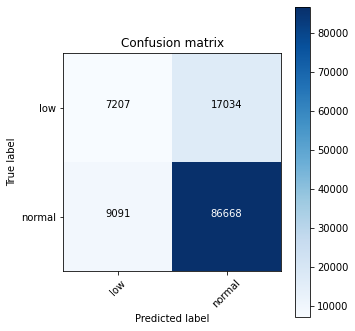

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(gnb2_cm, classes=reg2_class,
                      title='Confusion matrix')

In [ ]:
gnb2_mlcm=multilabel_confusion_matrix(Y_test, gnb2_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(gnb2_mlcm[i])

 [+] low 
[[86668  9091]
 [17034  7207]]
 [+] normal 
[[ 7207 17034]
 [ 9091 86668]]


### ***Logistic: 3 Categories***

In [ ]:
# X = df.drop(columns=['DBWT'])
# Y = pd.cut(df['DBWT'],
#                         bins = [227, 2500, 4500, 8165], labels=['low', 'medium', 'high'],include_lowest=True)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [ ]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_test)/len(Y_test))*100

Distribution of Each Category in Test Data:


medium    91.848333
low        7.200000
high       0.951667
Name: DBWT, dtype: float64

In [ ]:
print('Distribution of Each Category in Train Data:')
(pd.value_counts(Y_train)/len(Y_train))*100

Distribution of Each Category in Train Data:


medium    91.913542
low        7.118333
high       0.968125
Name: DBWT, dtype: float64

#### ***LogisticRegression***

In [ ]:
reg3_lr = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [ ]:
reg3_lr.score(X_test, Y_test.values.ravel())

0.925325

In [ ]:
reg3_y_pred = reg3_lr.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg3_y_pred))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00      1142
         low       0.67      0.18      0.29      8640
      medium       0.93      0.99      0.96    110218

    accuracy                           0.93    120000
   macro avg       0.53      0.39      0.42    120000
weighted avg       0.90      0.93      0.90    120000



In [ ]:
reg3_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg3_y_pred, 
                      binary=False)

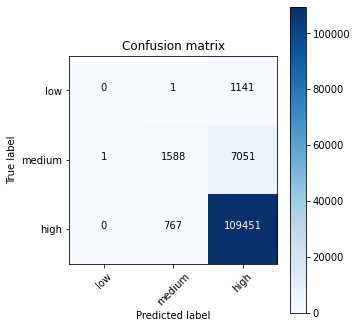

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg3_cm, classes=reg3_class,
                      title='Confusion matrix')

In [ ]:
reg3_mlcm=multilabel_confusion_matrix(Y_test, reg3_y_pred)
for i in range(0,3):
  print("\033[1m","[+]",reg3_class[i],"\033[0m")
  print(reg3_mlcm[i])

 [+] low 
[[118857      1]
 [  1142      0]]
 [+] medium 
[[110592    768]
 [  7052   1588]]
 [+] high 
[[  1590   8192]
 [   767 109451]]


#### ***Random Forest Classifier***

In [ ]:
reg3_rf = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train.values.ravel())

In [ ]:
reg3_rf.score(X_test, Y_test.values.ravel())

0.9260333333333334

In [ ]:
reg3_rf_y_pred = reg3_rf.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg3_rf_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        high       0.00      0.00      0.00      1142
         low       0.78      0.15      0.25      8640
      medium       0.93      1.00      0.96    110218

    accuracy                           0.93    120000
   macro avg       0.57      0.38      0.40    120000
weighted avg       0.91      0.93      0.90    120000



In [ ]:
reg3_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg3_rf_y_pred, 
                      binary=False)

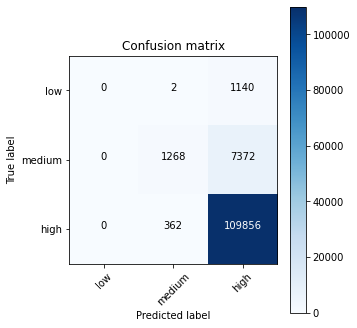

In [ ]:
np.set_printoptions(precision=2)
reg3_class = ['low', 'medium', 'high']
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg3_rf_cm, classes=reg3_class,
                      title='Confusion matrix')

In [ ]:
reg3_rf_mlcm=multilabel_confusion_matrix(Y_test, reg3_rf_y_pred)
for i in range(0,3):
  print("\033[1m","[+]",reg3_class[i],"\033[0m")
  print(reg3_rf_mlcm[i])

 [+] low 
[[118858      0]
 [  1142      0]]
 [+] medium 
[[110996    364]
 [  7372   1268]]
 [+] high 
[[  1270   8512]
 [   362 109856]]


#### ***Decision Tree Classifier***

In [ ]:
reg3_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

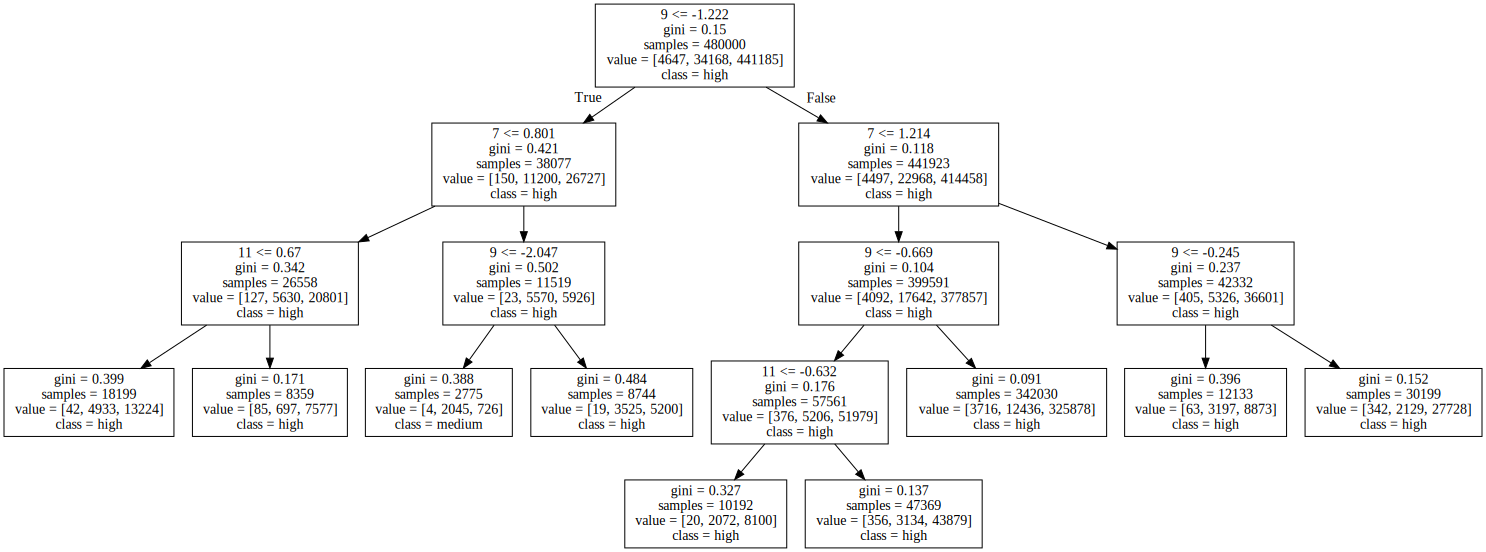

<Figure size 1080x1080 with 0 Axes>

In [ ]:
export_graphviz(reg3_dt, out_file="/content/drive/MyDrive/FDM/documents/reg3_dt_tree.dot", class_names=['low', 'medium', 'high'],feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg3_dt_tree.dot") as f:
  dot_graph = f.read()
dt3graph = pydotplus.graph_from_dot_data(dot_graph) 
dt3graph.write_svg("/content/drive/MyDrive/FDM/documents/reg3dt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph)

In [ ]:
reg3_dt.score(X_test, Y_test.values.ravel())

0.9211916666666666

In [ ]:
reg3_dt_y_pred = reg3_dt.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg3_dt_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        high       0.00      0.00      0.00      1142
         low       0.73      0.06      0.11      8640
      medium       0.92      1.00      0.96    110218

    accuracy                           0.92    120000
   macro avg       0.55      0.35      0.36    120000
weighted avg       0.90      0.92      0.89    120000



In [ ]:
reg3_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg3_dt_y_pred, 
                      binary=False)

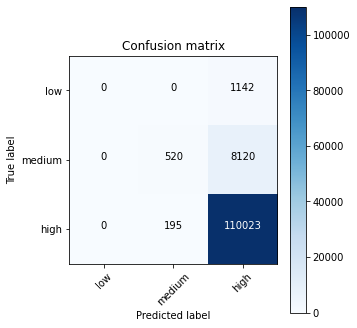

In [ ]:
np.set_printoptions(precision=2)
reg3_class = ['low', 'medium', 'high']
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg3_dt_cm, classes=reg3_class,
                      title='Confusion matrix')

In [ ]:
reg3_dt_mlcm=multilabel_confusion_matrix(Y_test, reg3_dt_y_pred)
for i in range(0,3):
  print("\033[1m","[+]",reg3_class[i],"\033[0m")
  print(reg3_dt_mlcm[i])

 [+] low 
[[118858      0]
 [  1142      0]]
 [+] medium 
[[111165    195]
 [  8120    520]]
 [+] high 
[[   520   9262]
 [   195 110023]]


#### ***Neural Network***

In [ ]:
nn3 = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [ ]:
nn3.score(X_test,Y_test)

0.9195916666666667

In [ ]:
nn3_y_pred = nn3.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, nn3_y_pred))

              precision    recall  f1-score   support

        high       0.07      0.01      0.02      1142
         low       0.53      0.26      0.35      8640
      medium       0.94      0.98      0.96    110218

    accuracy                           0.92    120000
   macro avg       0.51      0.42      0.44    120000
weighted avg       0.90      0.92      0.90    120000



In [ ]:
nn3_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn3_y_pred, 
                      binary=False)

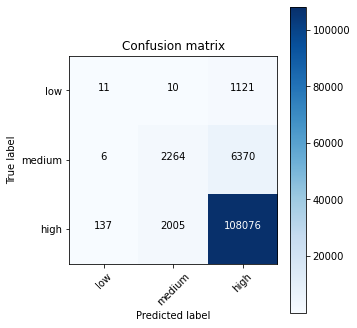

In [ ]:
np.set_printoptions(precision=2)
reg3_class = ['low', 'medium', 'high']
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(nn3_cm, classes=reg3_class,
                      title='Confusion matrix')

In [ ]:
nn3_mlcm=multilabel_confusion_matrix(Y_test, nn3_y_pred)
for i in range(0,3):
  print("\033[1m","[+]",reg3_class[i],"\033[0m")
  print(nn3_mlcm[i])

 [+] low 
[[118715    143]
 [  1131     11]]
 [+] medium 
[[109345   2015]
 [  6376   2264]]
 [+] high 
[[  2291   7491]
 [  2142 108076]]


#### ***GaussianNB***

In [ ]:
gnb3 = GaussianNB().fit(X_train, Y_train)

In [ ]:
gnb3.score(X_test,Y_test)

0.8953416666666667

In [ ]:
gnb3_y_pred = gnb3.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, gnb3_y_pred))

              precision    recall  f1-score   support

        high       0.12      0.01      0.02      1142
         low       0.32      0.29      0.31      8640
      medium       0.94      0.95      0.94    110218

    accuracy                           0.90    120000
   macro avg       0.46      0.42      0.42    120000
weighted avg       0.88      0.90      0.89    120000



In [ ]:
gnb3_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb3_y_pred, 
                      binary=False)

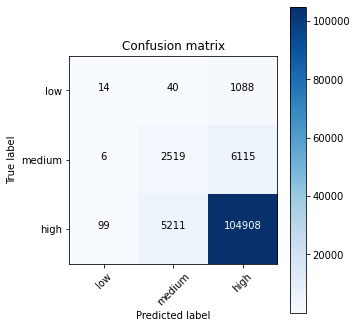

In [ ]:
np.set_printoptions(precision=2)
reg3_class = ['low', 'medium', 'high']
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(gnb3_cm, classes=reg3_class,
                      title='Confusion matrix')

In [ ]:
gnb3_mlcm=multilabel_confusion_matrix(Y_test, gnb3_y_pred)
for i in range(0,3):
  print("\033[1m","[+]",reg3_class[i],"\033[0m")
  print(gnb3_mlcm[i])

 [+] low 
[[118753    105]
 [  1128     14]]
 [+] medium 
[[106109   5251]
 [  6121   2519]]
 [+] high 
[[  2579   7203]
 [  5310 104908]]


### ***Logistic: 6 Categories***

In [ ]:
# X = df.drop(columns=['DBWT'])
# Y = pd.cut(df['DBWT'],
#                         bins = [227, 1000, 2000, 3000, 4000, 5000, 8165], labels=['LessThan1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', 'GreaterThan5000'],include_lowest=True)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [ ]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_test)/len(Y_test))*100

Distribution of Each Category in Test Data:


3000-4000          66.706667
2000-3000          23.543333
4000-5000           7.454167
1000-2000           2.060000
LessThan1000        0.137500
GreaterThan5000     0.098333
Name: DBWT, dtype: float64

In [ ]:
print('Distribution of Each Category in Train Data:')
(pd.value_counts(Y_train)/len(Y_train))*100

Distribution of Each Category in Train Data:


3000-4000          66.593125
2000-3000          23.610208
4000-5000           7.565833
1000-2000           2.005417
LessThan1000        0.136875
GreaterThan5000     0.088542
Name: DBWT, dtype: float64

#### ***LogisticRegression***

In [ ]:
reg6_lr = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [ ]:
reg6_lr.score(X_test, Y_test.values.ravel())

0.6894416666666666

In [ ]:
reg6_y_pred = reg6_lr.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg6_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-2000       0.58      0.32      0.42      2472
      2000-3000       0.55      0.19      0.28     28252
      3000-4000       0.70      0.95      0.81     80048
      4000-5000       0.43      0.01      0.01      8945
GreaterThan5000       0.00      0.00      0.00       118
   LessThan1000       0.00      0.00      0.00       165

       accuracy                           0.69    120000
      macro avg       0.38      0.25      0.25    120000
   weighted avg       0.64      0.69      0.62    120000



In [ ]:
reg6_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg6_y_pred, 
                      binary=False)

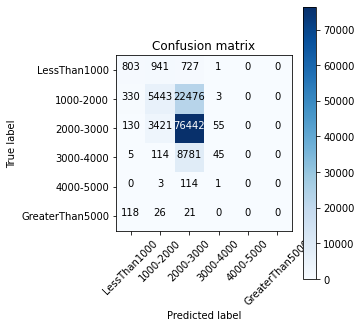

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg6_cm, classes=reg6_class,
                      title='Confusion matrix')

In [ ]:
reg6_mlcm=multilabel_confusion_matrix(Y_test, reg6_y_pred)
for i in range(0,6):
  print("\033[1m","[+]",reg6_class[i],"\033[0m")
  print(reg6_mlcm[i])

 [+] LessThan1000 
[[116945    583]
 [  1669    803]]
 [+] 1000-2000 
[[87243  4505]
 [22809  5443]]
 [+] 2000-3000 
[[ 7833 32119]
 [ 3606 76442]]
 [+] 3000-4000 
[[110995     60]
 [  8900     45]]
 [+] 4000-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119835      0]
 [   165      0]]


#### ***Random Forest Classifier***

In [ ]:
reg6_rf = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train.values.ravel())

In [ ]:
reg6_rf.score(X_test, Y_test.values.ravel())

0.6854583333333333

In [ ]:
reg6_rf_y_pred = reg6_rf.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg6_rf_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-2000       0.66      0.17      0.27      2472
      2000-3000       0.53      0.17      0.26     28252
      3000-4000       0.70      0.96      0.81     80048
      4000-5000       0.33      0.00      0.00      8945
GreaterThan5000       0.00      0.00      0.00       118
   LessThan1000       1.00      0.01      0.02       165

       accuracy                           0.69    120000
      macro avg       0.54      0.22      0.23    120000
   weighted avg       0.63      0.69      0.61    120000



In [ ]:
reg6_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg6_rf_y_pred, 
                      binary=False)

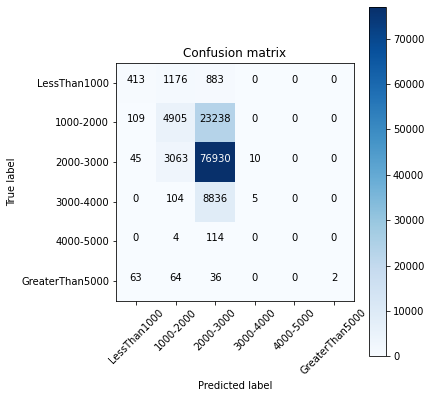

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(6,6))
_my_plot_confusion_matrix(reg6_rf_cm, classes=reg6_class,
                      title='Confusion matrix')

In [ ]:
reg6_rf_mlcm=multilabel_confusion_matrix(Y_test, reg6_rf_y_pred)
for i in range(0,6):
  print("\033[1m","[+]",reg6_class[i],"\033[0m")
  print(reg6_rf_mlcm[i])

 [+] LessThan1000 
[[117311    217]
 [  2059    413]]
 [+] 1000-2000 
[[87337  4411]
 [23347  4905]]
 [+] 2000-3000 
[[ 6845 33107]
 [ 3118 76930]]
 [+] 3000-4000 
[[111045     10]
 [  8940      5]]
 [+] 4000-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119835      0]
 [   163      2]]


#### ***Decision Tree Classifier***

In [ ]:
reg6_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

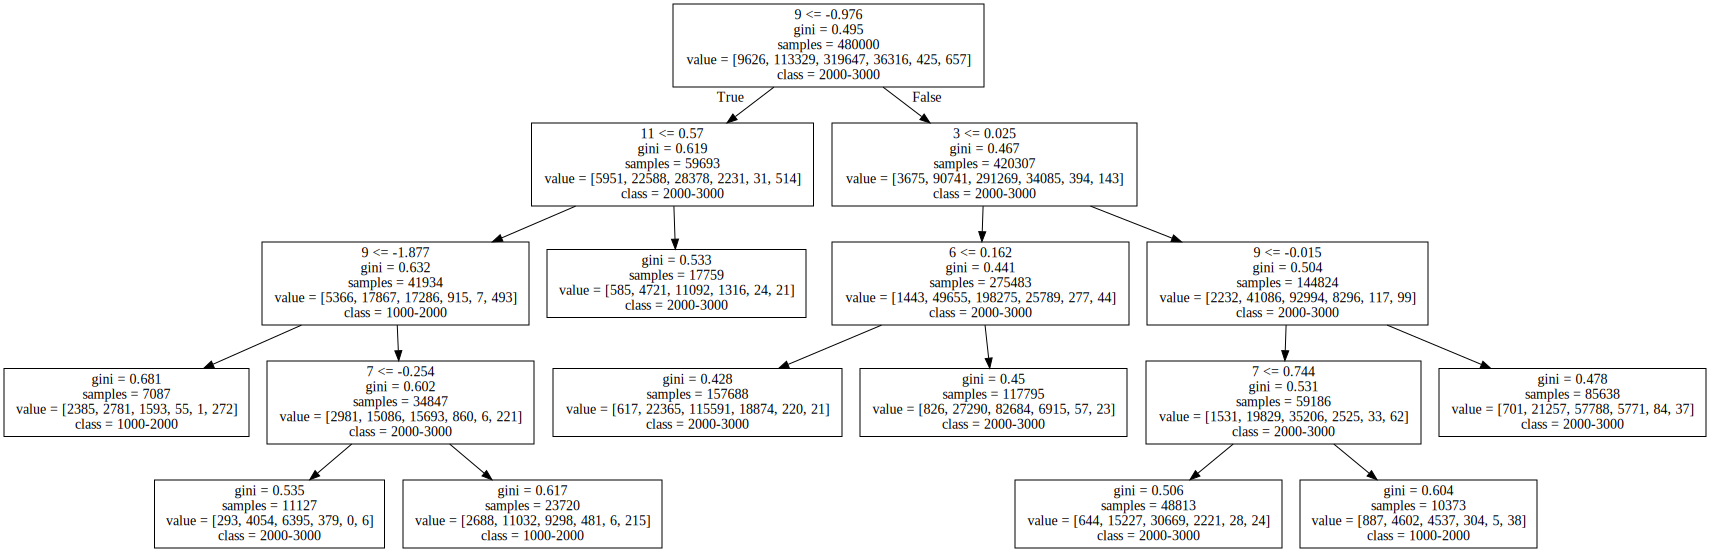

<Figure size 1080x1080 with 0 Axes>

In [ ]:
export_graphviz(reg6_dt, out_file="/content/drive/MyDrive/FDM/documents/reg6_dt_tree.dot", class_names=reg6_class,feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg6_dt_tree.dot") as f:
  dot_graph6 = f.read()
dt6graph = pydotplus.graph_from_dot_data(dot_graph6) 
dt6graph.write_svg("/content/drive/MyDrive/FDM/documents/reg6dt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph6)

In [ ]:
reg6_dt.score(X_test, Y_test.values.ravel())

0.6725916666666667

In [ ]:
reg6_dt_y_pred = reg6_dt.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg6_dt_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-2000       0.00      0.00      0.00      2472
      2000-3000       0.44      0.16      0.23     28252
      3000-4000       0.69      0.95      0.80     80048
      4000-5000       0.00      0.00      0.00      8945
GreaterThan5000       0.00      0.00      0.00       118
   LessThan1000       0.00      0.00      0.00       165

       accuracy                           0.67    120000
      macro avg       0.19      0.19      0.17    120000
   weighted avg       0.57      0.67      0.59    120000



In [ ]:
reg6_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg6_dt_y_pred, 
                      binary=False)

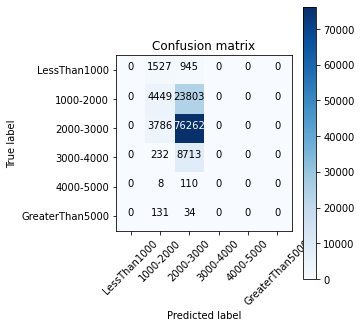

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg6_dt_cm, classes=reg6_class,
                      title='Confusion matrix')

In [ ]:
reg6_dt_mlcm=multilabel_confusion_matrix(Y_test, reg6_dt_y_pred)
for i in range(0,6):
  print("\033[1m","[+]",reg6_class[i],"\033[0m")
  print(reg6_dt_mlcm[i])

 [+] LessThan1000 
[[117528      0]
 [  2472      0]]
 [+] 1000-2000 
[[86064  5684]
 [23803  4449]]
 [+] 2000-3000 
[[ 6347 33605]
 [ 3786 76262]]
 [+] 3000-4000 
[[111055      0]
 [  8945      0]]
 [+] 4000-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119835      0]
 [   165      0]]


#### ***Neural Network***

In [ ]:
nn6 = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [ ]:
nn6.score(X_test,Y_test)

0.6853

In [ ]:
nn6_y_pred = nn6.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, nn6_y_pred))

                 precision    recall  f1-score   support

      1000-2000       0.54      0.27      0.36      2472
      2000-3000       0.52      0.23      0.32     28252
      3000-4000       0.71      0.94      0.81     80048
      4000-5000       0.24      0.01      0.02      8945
GreaterThan5000       0.07      0.01      0.02       118
   LessThan1000       0.16      0.12      0.14       165

       accuracy                           0.69    120000
      macro avg       0.37      0.26      0.28    120000
   weighted avg       0.63      0.69      0.62    120000



In [ ]:
nn6_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn6_y_pred, 
                      binary=False)

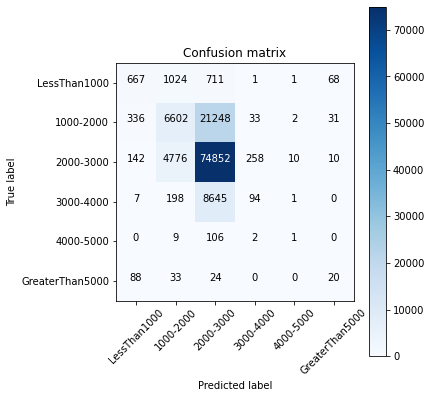

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(6,6))
_my_plot_confusion_matrix(nn6_cm, classes=reg6_class,
                      title='Confusion matrix')

In [ ]:
nn6_mlcm=multilabel_confusion_matrix(Y_test, nn6_y_pred)
for i in range(0,6):
  print("\033[1m","[+]",reg6_class[i],"\033[0m")
  print(nn6_mlcm[i])

 [+] LessThan1000 
[[116955    573]
 [  1805    667]]
 [+] 1000-2000 
[[85708  6040]
 [21650  6602]]
 [+] 2000-3000 
[[ 9218 30734]
 [ 5196 74852]]
 [+] 3000-4000 
[[110761    294]
 [  8851     94]]
 [+] 4000-5000 
[[119868     14]
 [   117      1]]
 [+] GreaterThan5000 
[[119726    109]
 [   145     20]]


#### ***GaussianNB***

In [ ]:
gnb6 = GaussianNB().fit(X_train, Y_train)

In [ ]:
gnb6.score(X_test,Y_test)

0.6484166666666666

In [ ]:
gnb6_y_pred = gnb6.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, gnb6_y_pred))

                 precision    recall  f1-score   support

      1000-2000       0.42      0.35      0.38      2472
      2000-3000       0.40      0.24      0.30     28252
      3000-4000       0.70      0.87      0.78     80048
      4000-5000       0.28      0.04      0.07      8945
GreaterThan5000       0.00      0.00      0.00       118
   LessThan1000       0.05      0.04      0.05       165

       accuracy                           0.65    120000
      macro avg       0.31      0.26      0.26    120000
   weighted avg       0.59      0.65      0.60    120000



In [ ]:
gnb6_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb6_y_pred, 
                      binary=False)

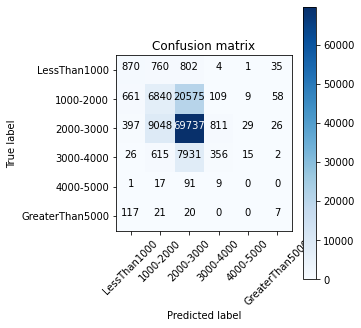

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(gnb6_cm, classes=reg6_class,
                      title='Confusion matrix')

In [ ]:
gnb6_mlcm=multilabel_confusion_matrix(Y_test, gnb6_y_pred)
for i in range(0,6):
  print("\033[1m","[+]",reg6_class[i],"\033[0m")
  print(gnb6_mlcm[i])

 [+] LessThan1000 
[[116326   1202]
 [  1602    870]]
 [+] 1000-2000 
[[81287 10461]
 [21412  6840]]
 [+] 2000-3000 
[[10533 29419]
 [10311 69737]]
 [+] 3000-4000 
[[110122    933]
 [  8589    356]]
 [+] 4000-5000 
[[119828     54]
 [   118      0]]
 [+] GreaterThan5000 
[[119714    121]
 [   158      7]]


### ***Logistic: 11 Categories***

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [ ]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_test)/len(Y_test))*100

Distribution of Each Category in Test Data:


3000-3500          39.659167
3500-4000          27.047500
2500-3000          18.540833
4000-4500           6.600833
2000-2500           5.002500
1500-2000           1.530000
4500-5000           0.853333
1000-1500           0.530000
500-1000            0.124167
GreaterThan5000     0.098333
LessThan500         0.013333
Name: DBWT, dtype: float64

In [ ]:
print('Distribution of Each Category in Train Data:')
(pd.value_counts(Y_train)/len(Y_train))*100

Distribution of Each Category in Train Data:


3000-3500          39.609792
3500-4000          26.983333
2500-3000          18.634167
4000-4500           6.686250
2000-2500           4.976042
1500-2000           1.470000
4500-5000           0.879583
1000-1500           0.535417
500-1000            0.125000
GreaterThan5000     0.088542
LessThan500         0.011875
Name: DBWT, dtype: float64

In [ ]:
# X = sample_data.drop(columns=['DBWT'])
# Y = pd.cut(df['DBWT'],
#                         bins = [227,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,8165], labels=['LessThan500','500-1000','1000-1500','1500-2000','2000-2500',
#           '2500-3000','3000-3500','3500-4000','4000-4500','4500-5000',
#           'GreaterThan5000'],include_lowest=True)

#### ***LogisticRegression***

In [ ]:
reg11 = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [ ]:
reg11.score(X_test, Y_test.values.ravel())

0.4242666666666667

In [ ]:
reg11_y_pred = reg11.predict(X_test)

In [ ]:
reg11_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg11_y_pred, 
                      binary=False)

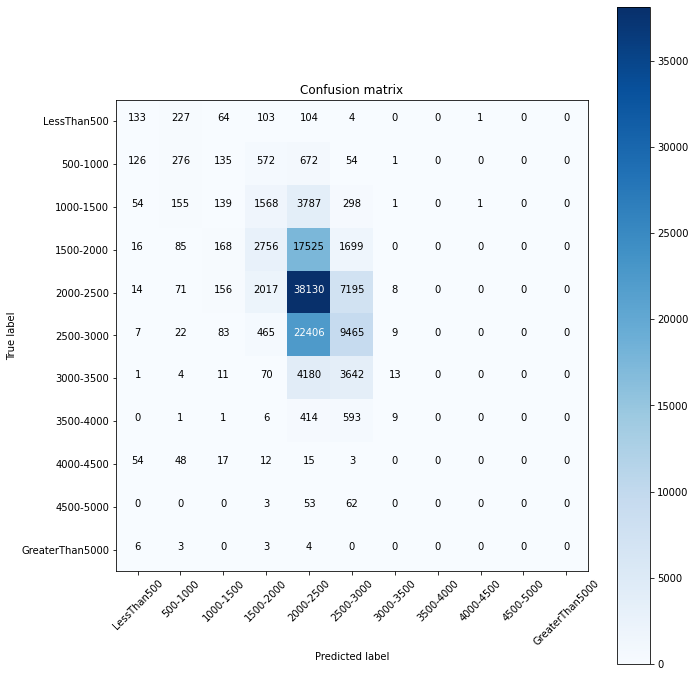

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
_my_plot_confusion_matrix(reg11_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
print(metrics.classification_report(Y_test, reg11_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-1500       0.32      0.21      0.25       636
      1500-2000       0.31      0.15      0.20      1836
      2000-2500       0.18      0.02      0.04      6003
      2500-3000       0.36      0.12      0.18     22249
      3000-3500       0.44      0.80      0.57     47591
      3500-4000       0.41      0.29      0.34     32457
      4000-4500       0.32      0.00      0.00      7921
      4500-5000       0.00      0.00      0.00      1024
       500-1000       0.00      0.00      0.00       149
GreaterThan5000       0.00      0.00      0.00       118
    LessThan500       0.00      0.00      0.00        16

       accuracy                           0.42    120000
      macro avg       0.21      0.15      0.14    120000
   weighted avg       0.39      0.42      0.36    120000



In [ ]:
reg11_mlcm=multilabel_confusion_matrix(Y_test, reg11_y_pred)

In [ ]:
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(reg11_mlcm[i])

 [+] LessThan500 
[[119086    278]
 [   503    133]]
 [+] 500-1000 
[[117548    616]
 [  1560    276]]
 [+] 1000-1500 
[[113362    635]
 [  5864    139]]
 [+] 1500-2000 
[[92932  4819]
 [19493  2756]]
 [+] 2000-2500 
[[23249 49160]
 [ 9461 38130]]
 [+] 2500-3000 
[[73993 13550]
 [22992  9465]]
 [+] 3000-3500 
[[112051     28]
 [  7908     13]]
 [+] 3500-4000 
[[118976      0]
 [  1024      0]]
 [+] 4000-4500 
[[119849      2]
 [   149      0]]
 [+] 4500-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119984      0]
 [    16      0]]


#### ***Random Forest Classifier***

In [ ]:
reg11_rf = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train.values.ravel())

In [ ]:
reg11_rf.score(X_test, Y_test.values.ravel())

0.409925

In [ ]:
reg11_rf_y_pred = reg11_rf.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg11_rf_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-1500       0.36      0.08      0.13       636
      1500-2000       0.33      0.08      0.12      1836
      2000-2500       0.24      0.02      0.04      6003
      2500-3000       0.32      0.12      0.18     22249
      3000-3500       0.42      0.79      0.55     47591
      3500-4000       0.39      0.27      0.32     32457
      4000-4500       0.24      0.00      0.00      7921
      4500-5000       0.00      0.00      0.00      1024
       500-1000       1.00      0.01      0.01       149
GreaterThan5000       0.00      0.00      0.00       118
    LessThan500       1.00      0.12      0.22        16

       accuracy                           0.41    120000
      macro avg       0.39      0.14      0.14    120000
   weighted avg       0.37      0.41      0.34    120000



In [ ]:
reg11_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg11_rf_y_pred, 
                      binary=False)

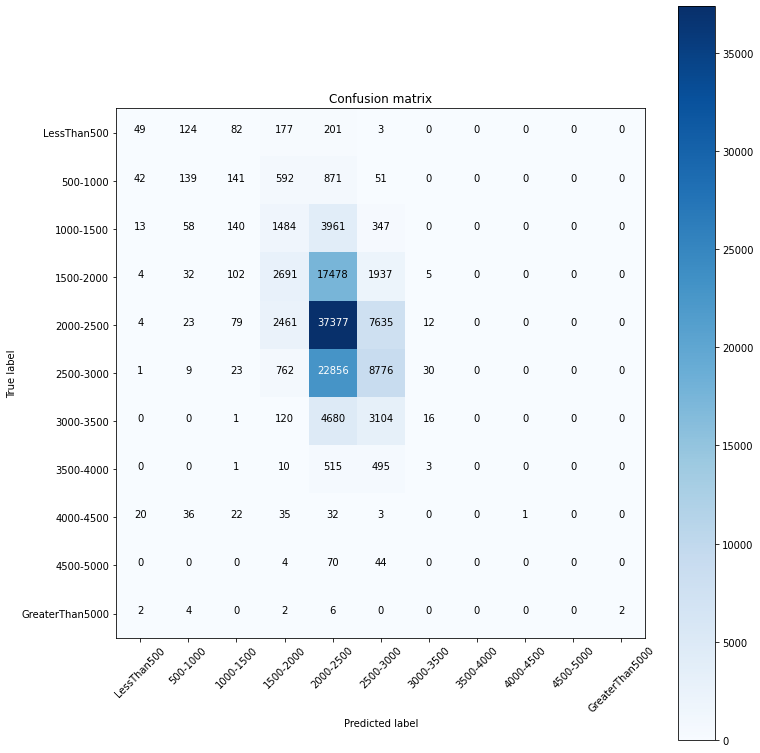

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
_my_plot_confusion_matrix(reg11_rf_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
reg11_rf_mlcm=multilabel_confusion_matrix(Y_test, reg11_rf_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(reg11_rf_mlcm[i])

 [+] LessThan500 
[[119278     86]
 [   587     49]]
 [+] 500-1000 
[[117878    286]
 [  1697    139]]
 [+] 1000-1500 
[[113546    451]
 [  5863    140]]
 [+] 1500-2000 
[[92104  5647]
 [19558  2691]]
 [+] 2000-2500 
[[21739 50670]
 [10214 37377]]
 [+] 2500-3000 
[[73924 13619]
 [23681  8776]]
 [+] 3000-3500 
[[112029     50]
 [  7905     16]]
 [+] 3500-4000 
[[118976      0]
 [  1024      0]]
 [+] 4000-4500 
[[119851      0]
 [   148      1]]
 [+] 4500-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119984      0]
 [    14      2]]


#### ***Decision Tree Classifier***

In [ ]:
reg11_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

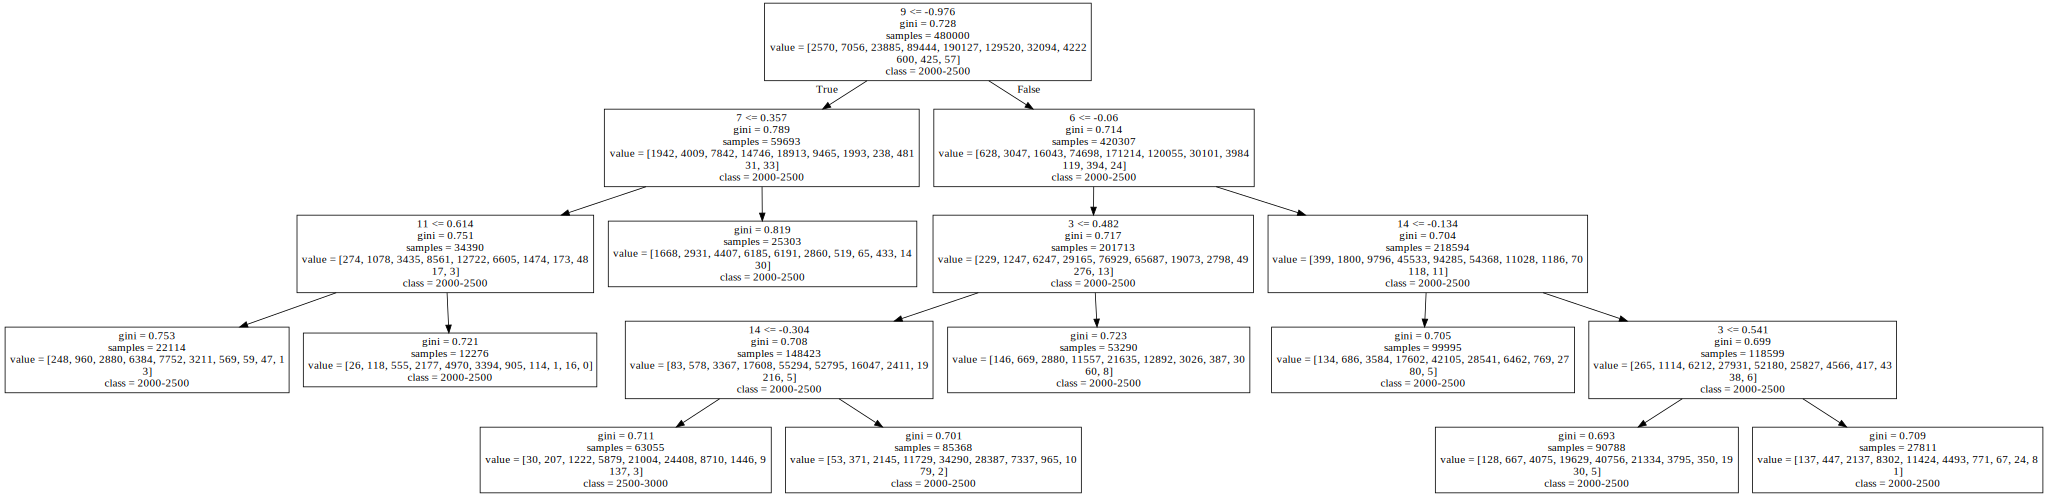

<Figure size 1080x1080 with 0 Axes>

In [ ]:
export_graphviz(reg11_dt, out_file="/content/drive/MyDrive/FDM/documents/reg11_dt_tree.dot", class_names=reg11_class,feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg11_dt_tree.dot") as f:
  dot_graph11 = f.read()
dt11graph = pydotplus.graph_from_dot_data(dot_graph11) 
dt11graph.write_svg("/content/drive/MyDrive/FDM/documents/reg11dt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph11)

In [ ]:
reg11_dt.score(X_test, Y_test.values.ravel())

0.403325

In [ ]:
reg11_dt_y_pred = reg11_dt.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg11_dt_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-1500       0.00      0.00      0.00       636
      1500-2000       0.00      0.00      0.00      1836
      2000-2500       0.00      0.00      0.00      6003
      2500-3000       0.00      0.00      0.00     22249
      3000-3500       0.41      0.89      0.56     47591
      3500-4000       0.39      0.19      0.25     32457
      4000-4500       0.00      0.00      0.00      7921
      4500-5000       0.00      0.00      0.00      1024
       500-1000       0.00      0.00      0.00       149
GreaterThan5000       0.00      0.00      0.00       118
    LessThan500       0.00      0.00      0.00        16

       accuracy                           0.40    120000
      macro avg       0.07      0.10      0.07    120000
   weighted avg       0.27      0.40      0.29    120000



In [ ]:
reg11_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg11_dt_y_pred, 
                      binary=False)

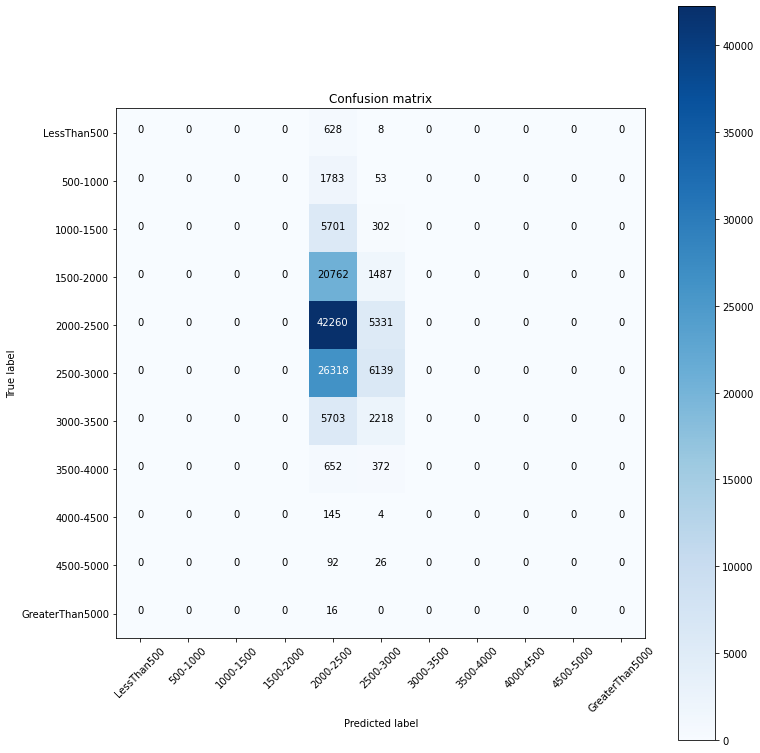

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
_my_plot_confusion_matrix(reg11_dt_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
reg11_dt_mlcm=multilabel_confusion_matrix(Y_test, reg11_dt_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(reg11_dt_mlcm[i])

 [+] LessThan500 
[[119364      0]
 [   636      0]]
 [+] 500-1000 
[[118164      0]
 [  1836      0]]
 [+] 1000-1500 
[[113997      0]
 [  6003      0]]
 [+] 1500-2000 
[[97751     0]
 [22249     0]]
 [+] 2000-2500 
[[10609 61800]
 [ 5331 42260]]
 [+] 2500-3000 
[[77742  9801]
 [26318  6139]]
 [+] 3000-3500 
[[112079      0]
 [  7921      0]]
 [+] 3500-4000 
[[118976      0]
 [  1024      0]]
 [+] 4000-4500 
[[119851      0]
 [   149      0]]
 [+] 4500-5000 
[[119882      0]
 [   118      0]]
 [+] GreaterThan5000 
[[119984      0]
 [    16      0]]


#### ***Neural Network***

In [ ]:
nn11 = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [ ]:
nn11.score(X_test,Y_test)

0.4206666666666667

In [ ]:
nn11_y_pred = nn11.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, nn11_y_pred))

                 precision    recall  f1-score   support

      1000-1500       0.30      0.35      0.32       636
      1500-2000       0.29      0.09      0.14      1836
      2000-2500       0.28      0.12      0.17      6003
      2500-3000       0.35      0.19      0.24     22249
      3000-3500       0.44      0.75      0.56     47591
      3500-4000       0.41      0.29      0.34     32457
      4000-4500       0.18      0.01      0.02      7921
      4500-5000       0.00      0.00      0.00      1024
       500-1000       0.09      0.05      0.07       149
GreaterThan5000       0.00      0.00      0.00       118
    LessThan500       0.17      0.06      0.09        16

       accuracy                           0.42    120000
      macro avg       0.23      0.17      0.18    120000
   weighted avg       0.38      0.42      0.37    120000



In [ ]:
nn11_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn11_y_pred, 
                      binary=False)

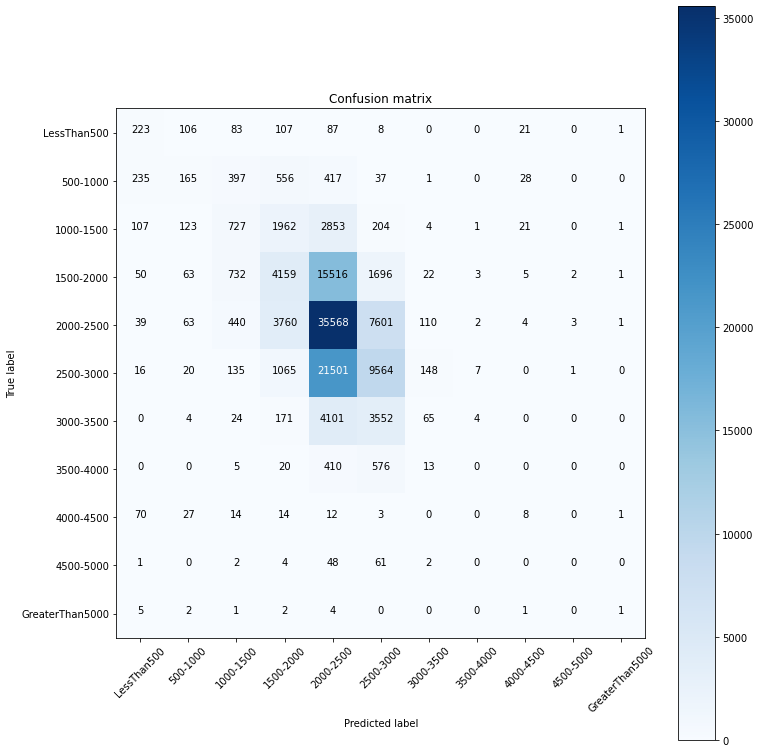

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
_my_plot_confusion_matrix(nn11_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
nn11_mlcm=multilabel_confusion_matrix(Y_test, nn11_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(nn11_mlcm[i])

 [+] LessThan500 
[[118841    523]
 [   413    223]]
 [+] 500-1000 
[[117756    408]
 [  1671    165]]
 [+] 1000-1500 
[[112164   1833]
 [  5276    727]]
 [+] 1500-2000 
[[90090  7661]
 [18090  4159]]
 [+] 2000-2500 
[[27460 44949]
 [12023 35568]]
 [+] 2500-3000 
[[73805 13738]
 [22893  9564]]
 [+] 3000-3500 
[[111779    300]
 [  7856     65]]
 [+] 3500-4000 
[[118959     17]
 [  1024      0]]
 [+] 4000-4500 
[[119771     80]
 [   141      8]]
 [+] 4500-5000 
[[119876      6]
 [   118      0]]
 [+] GreaterThan5000 
[[119979      5]
 [    15      1]]


#### ***GaussianNB***

In [ ]:
gnb11 = GaussianNB().fit(X_train, Y_train)

In [ ]:
gnb11.score(X_test,Y_test)

0.37799166666666667

In [ ]:
gnb11_y_pred = gnb11.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, gnb11_y_pred))

                 precision    recall  f1-score   support

      1000-1500       0.26      0.13      0.17       636
      1500-2000       0.24      0.19      0.21      1836
      2000-2500       0.15      0.10      0.12      6003
      2500-3000       0.28      0.15      0.19     22249
      3000-3500       0.44      0.53      0.48     47591
      3500-4000       0.36      0.49      0.42     32457
      4000-4500       0.21      0.02      0.03      7921
      4500-5000       0.11      0.01      0.01      1024
       500-1000       0.05      0.05      0.05       149
GreaterThan5000       0.00      0.00      0.00       118
    LessThan500       0.00      0.00      0.00        16

       accuracy                           0.38    120000
      macro avg       0.19      0.15      0.15    120000
   weighted avg       0.35      0.38      0.35    120000



In [ ]:
gnb11_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb11_y_pred, 
                      binary=False)

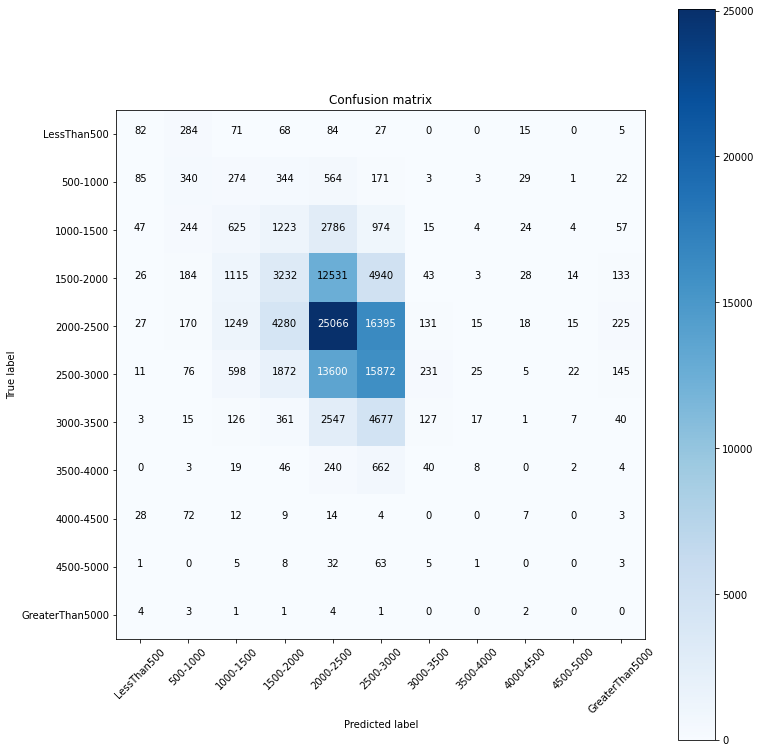

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
_my_plot_confusion_matrix(gnb11_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
gnb11_mlcm=multilabel_confusion_matrix(Y_test, gnb11_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(gnb11_mlcm[i])

 [+] LessThan500 
[[119132    232]
 [   554     82]]
 [+] 500-1000 
[[117113   1051]
 [  1496    340]]
 [+] 1000-1500 
[[110527   3470]
 [  5378    625]]
 [+] 1500-2000 
[[89539  8212]
 [19017  3232]]
 [+] 2000-2500 
[[40007 32402]
 [22525 25066]]
 [+] 2500-3000 
[[59629 27914]
 [16585 15872]]
 [+] 3000-3500 
[[111611    468]
 [  7794    127]]
 [+] 3500-4000 
[[118908     68]
 [  1016      8]]
 [+] 4000-4500 
[[119729    122]
 [   142      7]]
 [+] 4500-5000 
[[119817     65]
 [   118      0]]
 [+] GreaterThan5000 
[[119347    637]
 [    16      0]]


## ***Balancing Data in train set***

### ***2 Categories***

In [28]:
Y_train.value_counts()

normal    382906
low        97094
Name: DBWT, dtype: int64

In [29]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_train)/len(Y_train))*100

Distribution of Each Category in Test Data:


normal    79.772083
low       20.227917
Name: DBWT, dtype: float64

In [30]:
to_sample = pd.concat([X_train, Y_train], axis=1)

In [31]:
to_sample = to_sample.loc[to_sample["DBWT"] == "low"]

(0.5*(480000) - 97094)/0.5 = 285812

In [32]:
new_sample = to_sample.sample(n = 285812, replace = True)


In [33]:
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
new_sample.reset_index(drop=True, inplace=True)

In [34]:
X_train = pd.concat([X_train, new_sample.drop(columns=['DBWT'])])

In [35]:
Y_train = pd.concat([Y_train, new_sample['DBWT']])

In [36]:
Y_train.value_counts()

normal    382906
low       382906
Name: DBWT, dtype: int64

#### ***LogisticRegression***

In [37]:
reg2_re_lr = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [38]:
reg2_re_lr.score(X_test, Y_test.values.ravel())

0.7096166666666667

In [39]:
reg2_re_y_pred = reg2_re_lr.predict(X_test)

In [40]:
print(metrics.classification_report(Y_test, reg2_re_y_pred))

              precision    recall  f1-score   support

         low       0.38      0.67      0.48     24241
      normal       0.90      0.72      0.80     95759

    accuracy                           0.71    120000
   macro avg       0.64      0.70      0.64    120000
weighted avg       0.79      0.71      0.73    120000



#### ***Random Forest Classifer***

In [41]:
reg2_re_rf = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train.values.ravel())

In [42]:
reg2_re_rf.score(X_test, Y_test.values.ravel())

0.8165083333333333

In [43]:
reg2_re_rf_y_pred = reg2_re_rf.predict(X_test)

In [44]:
print(metrics.classification_report(Y_test, reg2_re_rf_y_pred))

              precision    recall  f1-score   support

         low       0.60      0.28      0.38     24241
      normal       0.84      0.95      0.89     95759

    accuracy                           0.82    120000
   macro avg       0.72      0.62      0.64    120000
weighted avg       0.79      0.82      0.79    120000



In [53]:
reg2_re_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg2_re_rf_y_pred, 
                      binary=False)

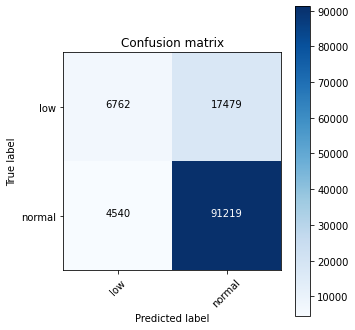

In [54]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg2_re_rf_cm, classes=reg2_class,
                      title='Confusion matrix')

In [55]:
reg2_re_rf_mlcm=multilabel_confusion_matrix(Y_test, reg2_re_rf_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(reg2_re_rf_mlcm[i])

 [+] low 
[[91219  4540]
 [17479  6762]]
 [+] normal 
[[ 6762 17479]
 [ 4540 91219]]


#### ***Decision Tree Classifer***

In [45]:
reg2_re_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

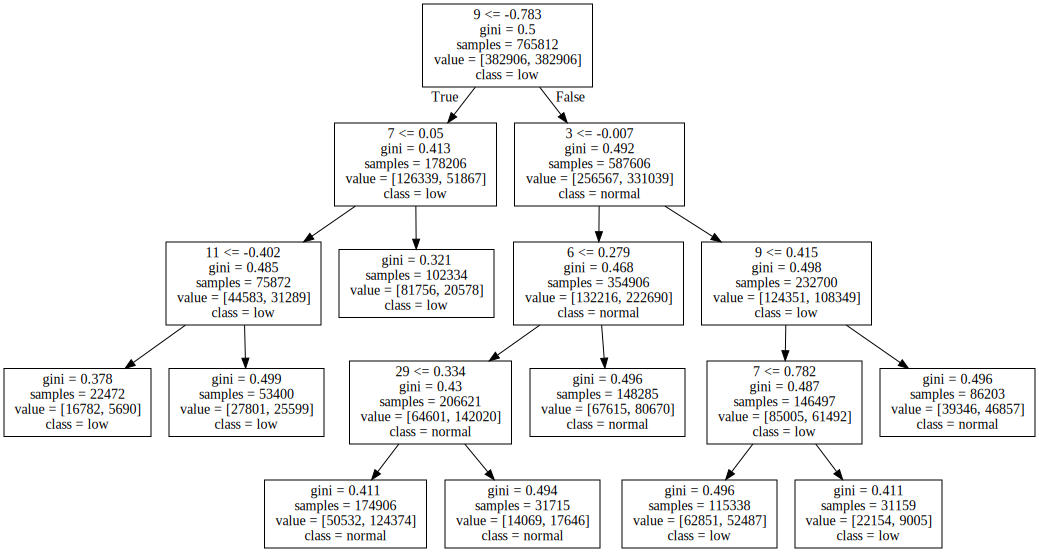

<Figure size 1080x1080 with 0 Axes>

In [46]:
export_graphviz(reg2_re_dt, out_file="/content/drive/MyDrive/FDM/documents/reg2_re_dt_tree.dot", class_names=['low', 'normal'],feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg2_re_dt_tree.dot") as f:
  dot_graph = f.read()
dt3graph = pydotplus.graph_from_dot_data(dot_graph) 
dt3graph.write_svg("/content/drive/MyDrive/FDM/documents/reg2_redt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph)

In [47]:
reg2_re_dt.score(X_test, Y_test.values.ravel())

0.6721583333333333

In [48]:
reg2_re_dt_y_pred = reg2_re_dt.predict(X_test)

In [49]:
print(metrics.classification_report(Y_test, reg2_re_dt_y_pred))

              precision    recall  f1-score   support

         low       0.32      0.55      0.40     24241
      normal       0.86      0.70      0.77     95759

    accuracy                           0.67    120000
   macro avg       0.59      0.63      0.59    120000
weighted avg       0.75      0.67      0.70    120000



In [50]:
reg2_re_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg2_re_dt_y_pred, 
                      binary=False)

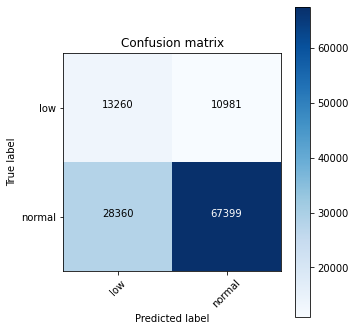

In [51]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg2_re_dt_cm, classes=reg2_class,
                      title='Confusion matrix')

In [52]:
reg2_re_dt_mlcm=multilabel_confusion_matrix(Y_test, reg2_re_dt_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(reg2_re_dt_mlcm[i])

 [+] low 
[[67399 28360]
 [10981 13260]]
 [+] normal 
[[13260 10981]
 [28360 67399]]


#### ***Neural Network***

In [56]:
nn2_re = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [57]:
nn2_re.score(X_test,Y_test)

0.7038166666666666

In [58]:
nn2_re_y_pred = nn2_re.predict(X_test)

In [59]:
print(metrics.classification_report(Y_test, nn2_re_y_pred))

              precision    recall  f1-score   support

         low       0.37      0.63      0.46     24241
      normal       0.89      0.72      0.80     95759

    accuracy                           0.70    120000
   macro avg       0.63      0.68      0.63    120000
weighted avg       0.78      0.70      0.73    120000



In [60]:
nn2_re_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn2_re_y_pred, 
                      binary=False)

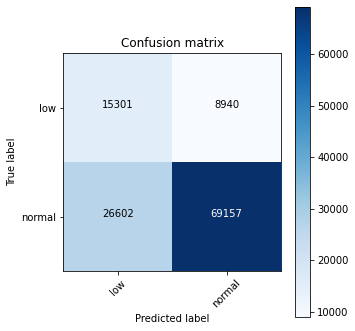

In [61]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(nn2_re_cm, classes=reg2_class,
                      title='Confusion matrix')

In [63]:
nn2_re_mlcm=multilabel_confusion_matrix(Y_test, nn2_re_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(nn2_re_mlcm[i])

 [+] low 
[[69157 26602]
 [ 8940 15301]]
 [+] normal 
[[15301  8940]
 [26602 69157]]


#### ***GaussionNB***

In [67]:
gnb2_re = GaussianNB().fit(X_train, Y_train)

In [68]:
gnb2_re.score(X_test,Y_test)

0.697975

In [69]:
gnb2_re_y_pred = gnb2_re.predict(X_test)

In [70]:
print(metrics.classification_report(Y_test, gnb2_re_y_pred))

              precision    recall  f1-score   support

         low       0.35      0.59      0.44     24241
      normal       0.87      0.73      0.79     95759

    accuracy                           0.70    120000
   macro avg       0.61      0.66      0.62    120000
weighted avg       0.77      0.70      0.72    120000



In [71]:
gnb2_re_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb2_re_y_pred, 
                      binary=False)

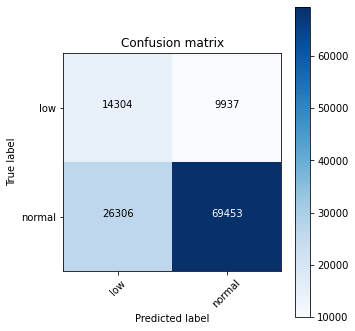

In [72]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(gnb2_re_cm, classes=reg2_class,
                      title='Confusion matrix')

In [73]:
gnb2_re_mlcm=multilabel_confusion_matrix(Y_test, gnb2_re_y_pred)
for i in range(0,2):
  print("\033[1m","[+]",reg2_class[i],"\033[0m")
  print(gnb2_re_mlcm[i])

 [+] low 
[[69453 26306]
 [ 9937 14304]]
 [+] normal 
[[14304  9937]
 [26306 69453]]


### ***11 Categories***

In [27]:
oversample = RandomOverSampler()
X_train_new, Y_train_new = oversample.fit_resample(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
Y_train.value_counts()

3000-3500          190127
3500-4000          129520
2500-3000           89444
4000-4500           32094
2000-2500           23885
1500-2000            7056
4500-5000            4222
1000-1500            2570
500-1000              600
GreaterThan5000       425
LessThan500            57
Name: DBWT, dtype: int64

In [29]:
pd.value_counts(Y_train_new)

4000-4500          190127
2000-2500          190127
1500-2000          190127
4500-5000          190127
500-1000           190127
2500-3000          190127
3000-3500          190127
3500-4000          190127
GreaterThan5000    190127
LessThan500        190127
1000-1500          190127
dtype: int64

In [30]:
print('Distribution of Each Category in Test Data:')
(pd.value_counts(Y_train_new)/len(Y_train_new))*100

Distribution of Each Category in Test Data:


4000-4500          9.090909
2000-2500          9.090909
1500-2000          9.090909
4500-5000          9.090909
500-1000           9.090909
2500-3000          9.090909
3000-3500          9.090909
3500-4000          9.090909
GreaterThan5000    9.090909
LessThan500        9.090909
1000-1500          9.090909
dtype: float64

In [31]:
X_train = pd.DataFrame(X_train_new, columns=X_train.columns)
Y_train = pd.Series(Y_train_new).astype('category')

#### ***LogisticRegression***

In [75]:
reg11_re_lr = LogisticRegression(solver="saga").fit(X_train, Y_train.values.ravel())

In [76]:
reg11_re_lr.score(X_test, Y_test.values.ravel())

0.21530833333333332

In [77]:
reg11_re_y_pred = reg11_re_lr.predict(X_test)

In [78]:
print(metrics.classification_report(Y_test, reg11_re_y_pred))

                 precision    recall  f1-score   support

      1000-1500       0.16      0.31      0.21       636
      1500-2000       0.07      0.22      0.10      1836
      2000-2500       0.13      0.20      0.16      6003
      2500-3000       0.28      0.29      0.29     22249
      3000-3500       0.48      0.21      0.30     47591
      3500-4000       0.35      0.17      0.23     32457
      4000-4500       0.12      0.19      0.15      7921
      4500-5000       0.03      0.25      0.05      1024
       500-1000       0.04      0.40      0.08       149
GreaterThan5000       0.00      0.42      0.01       118
    LessThan500       0.00      0.44      0.00        16

       accuracy                           0.22    120000
      macro avg       0.15      0.28      0.14    120000
   weighted avg       0.36      0.22      0.25    120000



#### ***Random Forest Classifer***

In [ ]:
reg11_re_rf = RandomForestClassifier(n_estimators=50).fit(X_train, Y_train.values.ravel())

In [ ]:
reg11_re_rf.score(X_test, Y_test.values.ravel())

0.8165083333333333

In [ ]:
reg11_re_rf_y_pred = reg11_re_rf.predict(X_test)

In [ ]:
print(metrics.classification_report(Y_test, reg11_re_rf_y_pred))

              precision    recall  f1-score   support

         low       0.60      0.28      0.38     24241
      normal       0.84      0.95      0.89     95759

    accuracy                           0.82    120000
   macro avg       0.72      0.62      0.64    120000
weighted avg       0.79      0.82      0.79    120000



In [ ]:
reg11_re_rf_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg11_re_rf_y_pred, 
                      binary=False)

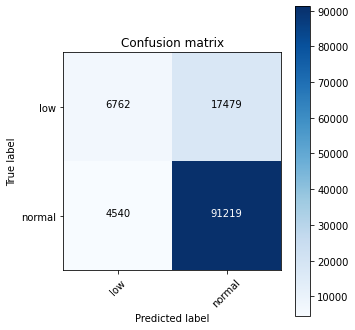

In [ ]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg11_re_rf_cm, classes=reg11_class,
                      title='Confusion matrix')

In [ ]:
reg11_re_rf_mlcm=multilabel_confusion_matrix(Y_test, reg11_re_rf_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(reg11_re_rf_mlcm[i])

 [+] low 
[[91219  4540]
 [17479  6762]]
 [+] normal 
[[ 6762 17479]
 [ 4540 91219]]


#### ***Decision Tree Classifer***

In [39]:
reg11_re_dt = DecisionTreeClassifier(max_depth=9,max_leaf_nodes=9).fit(X_train, Y_train.values.ravel())

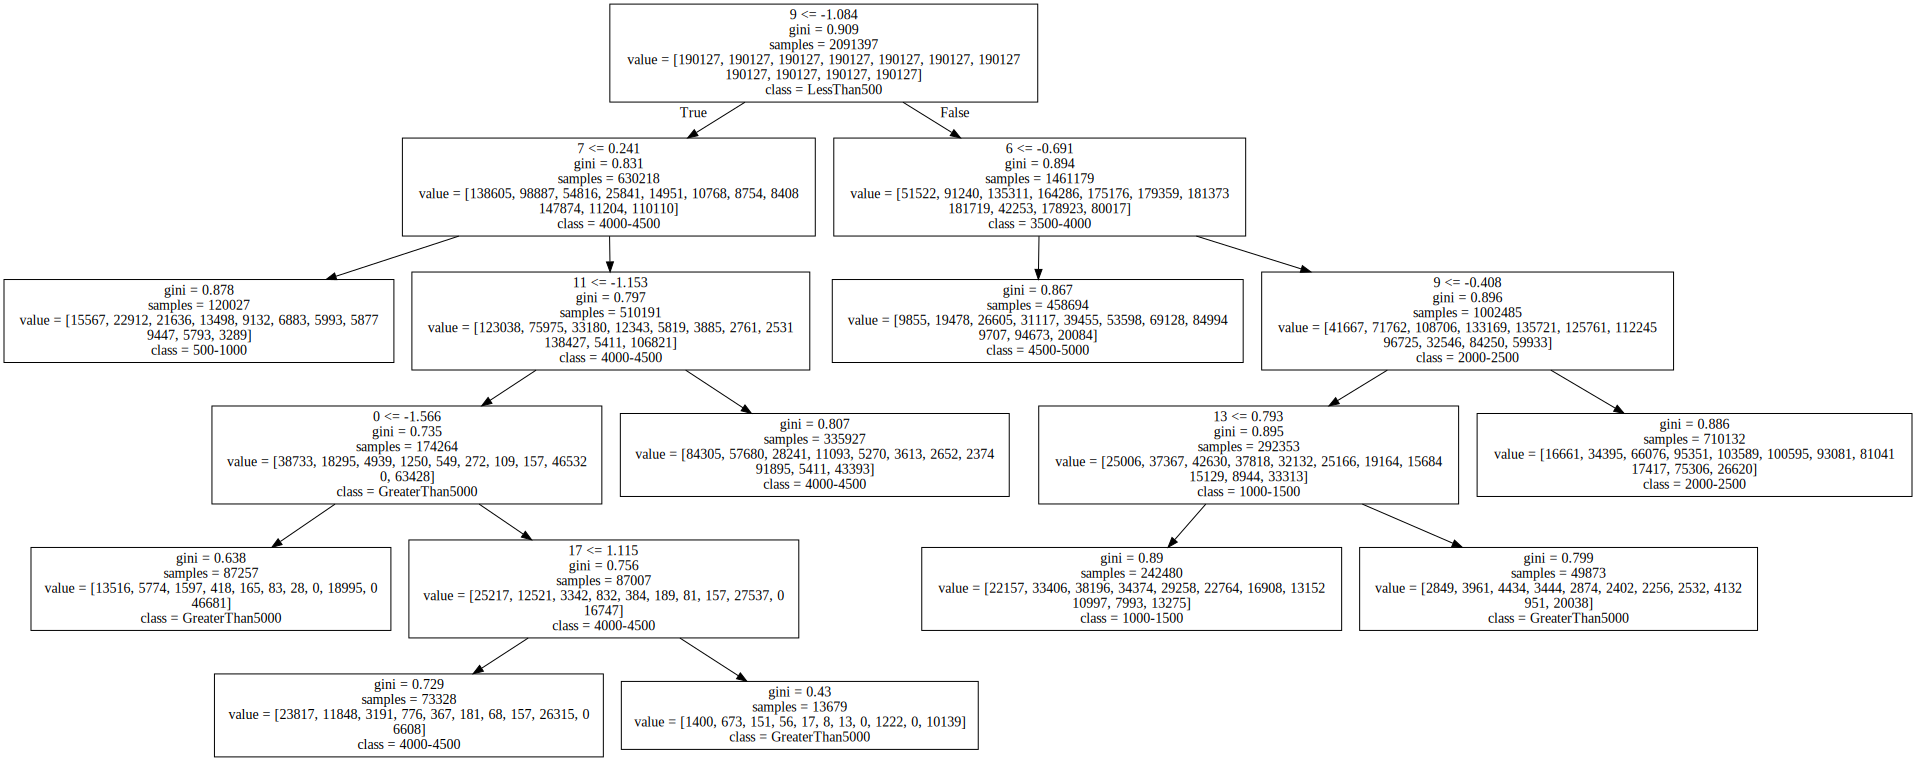

<Figure size 1080x1080 with 0 Axes>

In [40]:
export_graphviz(reg11_re_dt, out_file="/content/drive/MyDrive/FDM/documents/reg11_re_dt_tree.dot", class_names=reg11_class,feature_names=X_train.columns)
with open("/content/drive/MyDrive/FDM/documents/reg11_re_dt_tree.dot") as f:
  dot_graph = f.read()
dt3graph = pydotplus.graph_from_dot_data(dot_graph) 
dt3graph.write_svg("/content/drive/MyDrive/FDM/documents/reg11_redt.svg")
plt.figure(figsize=(15,15))
graphviz.Source(dot_graph)

In [41]:
reg11_re_dt.score(X_test, Y_test.values.ravel())

0.2298

In [42]:
reg11_re_dt_y_pred = reg11_re_dt.predict(X_test)

In [43]:
print(metrics.classification_report(Y_test, reg11_re_dt_y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

      1000-1500       0.00      0.00      0.00       636
      1500-2000       0.04      0.12      0.05      1836
      2000-2500       0.07      0.20      0.10      6003
      2500-3000       0.00      0.00      0.00     22249
      3000-3500       0.42      0.55      0.48     47591
      3500-4000       0.00      0.00      0.00     32457
      4000-4500       0.00      0.00      0.00      7921
      4500-5000       0.00      0.00      0.00      1024
       500-1000       0.02      0.61      0.03       149
GreaterThan5000       0.00      0.44      0.00       118
    LessThan500       0.00      0.12      0.00        16

       accuracy                           0.23    120000
      macro avg       0.05      0.19      0.06    120000
   weighted avg       0.17      0.23      0.20    120000



In [44]:
reg11_re_dt_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=reg11_re_dt_y_pred, 
                      binary=False)

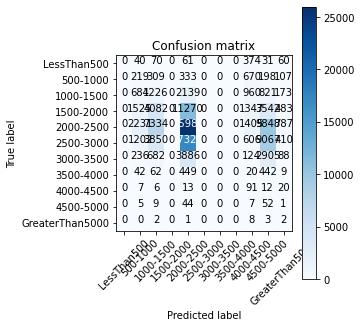

In [45]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(reg11_re_dt_cm, classes=reg11_class,
                      title='Confusion matrix')

In [46]:
reg11_re_dt_mlcm=multilabel_confusion_matrix(Y_test, reg11_re_dt_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(reg11_re_dt_mlcm[i])

 [+] LessThan500 
[[119364      0]
 [   636      0]]
 [+] 500-1000 
[[112192   5972]
 [  1617    219]]
 [+] 1000-1500 
[[97591 16406]
 [ 4777  1226]]
 [+] 1500-2000 
[[97751     0]
 [22249     0]]
 [+] 2000-2500 
[[36891 35518]
 [21605 25986]]
 [+] 2500-3000 
[[87543     0]
 [32457     0]]
 [+] 3000-3500 
[[112079      0]
 [  7921      0]]
 [+] 3500-4000 
[[118976      0]
 [  1024      0]]
 [+] 4000-4500 
[[114330   5521]
 [    58     91]]
 [+] 4500-5000 
[[93013 26869]
 [   66    52]]
 [+] GreaterThan5000 
[[117846   2138]
 [    14      2]]


#### ***Neural Network***

In [32]:
nn11_re = MLPClassifier(max_iter=500,hidden_layer_sizes=(100,100), activation='relu').fit(X_train,Y_train)

In [33]:
nn11_re.score(X_test,Y_test)

0.2716

In [34]:
nn11_re_y_pred = nn11_re.predict(X_test)

In [35]:
print(metrics.classification_report(Y_test, nn11_re_y_pred))

                 precision    recall  f1-score   support

      1000-1500       0.11      0.22      0.14       636
      1500-2000       0.11      0.46      0.18      1836
      2000-2500       0.13      0.33      0.19      6003
      2500-3000       0.31      0.12      0.17     22249
      3000-3500       0.47      0.43      0.44     47591
      3500-4000       0.36      0.09      0.14     32457
      4000-4500       0.13      0.47      0.21      7921
      4500-5000       0.02      0.15      0.03      1024
       500-1000       0.03      0.06      0.04       149
GreaterThan5000       0.00      0.02      0.01       118
    LessThan500       0.03      0.06      0.04        16

       accuracy                           0.27    120000
      macro avg       0.16      0.22      0.15    120000
   weighted avg       0.36      0.27      0.27    120000



In [36]:
nn11_re_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=nn11_re_y_pred, 
                      binary=False)

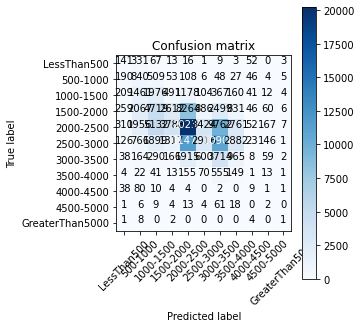

In [37]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(nn11_re_cm, classes=reg11_class,
                      title='Confusion matrix')

In [38]:
nn11_re_mlcm=multilabel_confusion_matrix(Y_test, nn11_re_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(nn11_re_mlcm[i])

 [+] LessThan500 
[[118188   1176]
 [   495    141]]
 [+] 500-1000 
[[111303   6861]
 [   996    840]]
 [+] 1000-1500 
[[101321  12676]
 [  4027   1976]]
 [+] 1500-2000 
[[91900  5851]
 [19637  2612]]
 [+] 2000-2500 
[[49283 23126]
 [27359 20232]]
 [+] 2500-3000 
[[82448  5095]
 [29541  2916]]
 [+] 3000-3500 
[[87868 24211]
 [ 4207  3714]]
 [+] 3500-4000 
[[111329   7647]
 [   875    149]]
 [+] 4000-4500 
[[119578    273]
 [   140      9]]
 [+] 4500-5000 
[[119420    462]
 [   116      2]]
 [+] GreaterThan5000 
[[119954     30]
 [    15      1]]


#### ***GaussionNB***

In [31]:
gnb11_re = GaussianNB().fit(X_train, Y_train)

In [32]:
gnb11_re.score(X_test,Y_test)

0.16065

In [33]:
gnb11_re_y_pred = gnb11_re.predict(X_test)

In [34]:
print(metrics.classification_report(Y_test, gnb11_re_y_pred))

                 precision    recall  f1-score   support

      1000-1500       0.13      0.28      0.18       636
      1500-2000       0.08      0.21      0.12      1836
      2000-2500       0.09      0.16      0.12      6003
      2500-3000       0.28      0.18      0.22     22249
      3000-3500       0.47      0.13      0.20     47591
      3500-4000       0.29      0.14      0.19     32457
      4000-4500       0.10      0.34      0.16      7921
      4500-5000       0.02      0.21      0.04      1024
       500-1000       0.02      0.36      0.05       149
GreaterThan5000       0.00      0.42      0.01       118
    LessThan500       0.00      0.44      0.00        16

       accuracy                           0.16    120000
      macro avg       0.14      0.26      0.12    120000
   weighted avg       0.33      0.16      0.19    120000



In [35]:
gnb11_re_cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=gnb11_re_y_pred, 
                      binary=False)

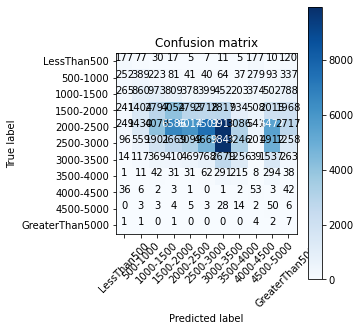

In [36]:
np.set_printoptions(precision=2)
plt.figure(figsize=(5,5))
_my_plot_confusion_matrix(gnb11_re_cm, classes=reg11_class,
                      title='Confusion matrix')

In [37]:
gnb11_re_mlcm=multilabel_confusion_matrix(Y_test, gnb11_re_y_pred)
for i in range(0,11):
  print("\033[1m","[+]",reg11_class[i],"\033[0m")
  print(gnb11_re_mlcm[i])

 [+] LessThan500 
[[118209   1155]
 [   459    177]]
 [+] 500-1000 
[[113696   4468]
 [  1447    389]]
 [+] 1000-1500 
[[104551   9446]
 [  5030    973]]
 [+] 1500-2000 
[[87140 10611]
 [18195  4054]]
 [+] 2000-2500 
[[65587  6822]
 [41577  6014]]
 [+] 2500-3000 
[[76045 11498]
 [27790  4667]]
 [+] 3000-3500 
[[88655 23424]
 [ 5242  2679]]
 [+] 3500-4000 
[[110193   8783]
 [   809    215]]
 [+] 4000-4500 
[[117718   2133]
 [    96     53]]
 [+] 4500-5000 
[[105037  14845]
 [    68     50]]
 [+] GreaterThan5000 
[[112447   7537]
 [     9      7]]
